# `PHÂN TÍCH CÁC YẾU TỐ ẢNH HƯỞNG ĐẾN DOANH THU TOÀN CẦU`

In [ ]:
import matplotlib.pyplot as plt #đặt tên viết tắt
import pandas as pd  
import numpy as np

# Đọc dữ liệu từ tệp csv
df = pd.read_csv("D:\hnhi\DE AN\IMDB_Movies_Dataset.csv")
    #BẤT KỲ THAY ĐỔI NÀO TRÊN df CHỈ ẢNH HƯỞNG ĐẾN DataFrame TRONG BỘ NHỚ
        #FILE csv GỐC VẪN GIỮ NGUYÊN 

df.head(3)

,Unnamed: 0,Title,Average Rating,Director,Writer,Metascore,Cast,Release Date,Country of Origin,Languages,Budget,Worldwide Gross,Runtime
0,0,The Shawshank Redemption,9.3,Frank Darabont,"Stephen King, Frank Darabont",82.0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...","October 14, 1994 (India)",United States,English,"$25,000,000 (estimated)","$29,332,133",2 hours 22 minutes
1,1,Attack on Titan the Movie: The Last Attack,9.3,Yûichirô Hayashi,"Natsuki Hanae, Yoshimasa Hosoya, Marina Inoue",NaN,"Natsuki Hanae, Yoshimasa Hosoya, Marina Inoue,...","November 8, 2024 (Japan)",Japan,Japanese,NaN,"$3,513,659",2 hours 25 minutes
2,2,The Godfather,9.2,Francis Ford Coppola,"Mario Puzo, Francis Ford Coppola",100.0,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",1978 (India),United States,"English, Italian, Latin","$6,000,000 (estimated)","$250,342,198",2 hours 55 minutes


In [332]:
# xóa cột không cần thiết
df.drop(columns=["Unnamed: 0"], axis=1, inplace=True)

In [ ]:
# Thông tin tổng quát của df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4989 entries, 0 to 4988
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              4989 non-null   object 
 1   Average Rating     4989 non-null   float64
 2   Director           4989 non-null   object 
 3   Writer             4988 non-null   object 
 4   Metascore          3055 non-null   float64
 5   Cast               4982 non-null   object 
 6   Release Date       4989 non-null   object 
 7   Country of Origin  4986 non-null   object 
 8   Languages          4968 non-null   object 
 9   Budget             2651 non-null   object 
 10  Worldwide Gross    3895 non-null   object 
 11  Runtime            4989 non-null   object 
dtypes: float64(2), object(10)
memory usage: 467.8+ KB


**Các vấn đề cần xử lý:**

1) Kiểu dữ liệu (object) của Budget, Worldwide Gross, Runtime nên chuyển thành float/int để phân tích số liệu.

2) Thiếu dữ liệu: đặc biệt ở các cột Metascore, Budget, Gross → cần xử lý:
- Bỏ dòng thiếu (dropna) hoặc
- Điền giá trị ước lượng (fillna) hoặc
- Xử lý riêng từng trường hợp tuỳ theo mục tiêu phân tích.

3) Chuyển đổi ngày: Release Date là object, nên cần chuyển thành datetime để xử lý theo thời gian.



# LÀM SẠCH DỮ LIỆU

### PHÂN LOẠI CÁC CỘT

In [334]:
# HÀM PHÂN LOẠI CÁC CỘT THEO KIỂU DỮ LIỆU VÀ LƯỢNG GIÁ TRỊ DUY NHẤT
def get_cols_names(df: pd.DataFrame, cat_threshold: int = 10, car_threshold: int = 20):
    
    # BƯỚC 1: TÁCH CÁC CỘT THEO KIỂU DỮ LIỆU
    cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
    num_cols = df.select_dtypes(exclude=["object"]).columns.tolist()
        # cat_cols: chứa các cột kiểu object → thường là dạng chuỗi (categorical).
        # num_cols: chứa các cột còn lại (kiểu số, float, int...).

    # BƯỚC 2: tÌM CỘT KIỂU OBJECT NHƯNG CÓ QUÁ NHIỀU GIÁ TRỊ KHÁC NHAU
    cat_but_car_cols = [col for col in cat_cols if df[col].nunique() > car_threshold]
        # categorical but cardinal → mặc dù kiểu object, nhưng có quá nhiều giá trị khác nhau (unique values).
    
    # BƯỚC 3: TÌM CỘT KIỂU SỐ NHƯNG CÓ QUÁ ÍT GIÁ TRỊ KHÁC NHAU -> CÓ THỂ XEM NHƯ CATEGORICAL
    num_but_cat_cols = [col for col in num_cols if df[col].nunique() < cat_threshold]
        # Ví dụ: cột rating chỉ có giá trị từ 1 đến 5, dù là số, nhưng có thể xem như categorical.

    # BƯỚC 4: CẬP NHẬT LẠI CÁC DANH SÁCH
    # Combining(ket hop) categorical features and excluding(loai tru categorical but cardinal features
    cat_cols += num_but_cat_cols
    cat_cols = [col for col in cat_cols if col not in cat_but_car_cols]
        # Bổ sung num_but_cat_cols vào cat_cols.
        # Loại bỏ các cột thuộc dạng cardinal khỏi danh sách categorical.

    # Loại bỏ những cột số được xem là danh mục khỏi danh sách num_cols.
    # Exluding numeric-looking categorical features from numeric
    num_cols = [col for col in num_cols if col not in num_but_cat_cols]

    return cat_cols, num_cols, num_but_cat_cols, cat_but_car_cols


# IN RA CÁC CỘT
def print_cols_summary(cat_cols, num_cols, num_but_cat_cols=None, cat_but_car_cols=None):
    print(f"Categorical columns (bao gồm cả những cột số trông giống categorical columns): {cat_cols}\n\nTrong số đó, các cột số nhưng trông như phân loại: {num_but_cat_cols}\n")
    print("-" * 50)
    print(f"\nNumeric columns: {num_cols}\n")
    print("-" * 50)
    print(f"\nCategorical but cardinal columns (Các cột phân loại nhưng có quá nhiều giá trị khác nhau (cardinal)):\n {cat_but_car_cols}\n")
    print("-" * 50)

    for col in cat_cols:
        print(f"\n'Cột {col}' chứa {df[col].nunique()} giá trị duy nhất: {df[col].unique().tolist()}")

    print("\n", "-" * 50)
    
    for col in num_cols:
        print(f"\n'Cột {col}' có giá trị nằm trong khoảng từ {df.describe().loc['min', col]} đến {df.describe().loc['max', col]}")

    print("\n", "-" * 50)
    for col in cat_but_car_cols:
        print(f"\n'Cột {col}' có tổng cộng {df[col].nunique()} giá trị duy nhất.")

cat_cols, num_cols, num_but_cat_cols, cat_but_car_cols = get_cols_names(df)
print_cols_summary(cat_cols, num_cols, num_but_cat_cols, cat_but_car_cols)

Categorical columns (bao gồm cả những cột số trông giống categorical columns): []

Trong số đó, các cột số nhưng trông như phân loại: []

--------------------------------------------------

Numeric columns: ['Average Rating', 'Metascore']

--------------------------------------------------

Categorical but cardinal columns (Các cột phân loại nhưng có quá nhiều giá trị khác nhau (cardinal)):
 ['Title', 'Director', 'Writer', 'Cast', 'Release Date', 'Country of Origin', 'Languages', 'Budget', 'Worldwide Gross', 'Runtime']

--------------------------------------------------

 --------------------------------------------------

'Cột Average Rating' có giá trị nằm trong khoảng từ 7.2 đến 9.3

'Cột Metascore' có giá trị nằm trong khoảng từ 25.0 đến 100.0

 --------------------------------------------------

'Cột Title' có tổng cộng 4927 giá trị duy nhất.

'Cột Director' có tổng cộng 2648 giá trị duy nhất.

'Cột Writer' có tổng cộng 4422 giá trị duy nhất.

'Cột Cast' có tổng cộng 4981 giá trị 

In [335]:
#ĐẾM SỐ LƯỢNG DÒNG BỊ TRÙNG LẶP (k bao gồm dòng đầu tiên của nhóm lặp)
df.duplicated().sum() 


0

In [336]:
# ĐẾM SỐ LƯỢNG DÒNG BỊ THIẾU DỮ LIỆU
df.isna().sum() 

Title                   0
Average Rating          0
Director                0
Writer                  1
Metascore            1934
Cast                    7
Release Date            0
Country of Origin       3
Languages              21
Budget               2338
Worldwide Gross      1094
Runtime                 0
dtype: int64

In [337]:
#xóa dòng bị thiếu dữ liệu
df = df.dropna() 

 
df.isna().sum()
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1926 entries, 0 to 4976
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              1926 non-null   object 
 1   Average Rating     1926 non-null   float64
 2   Director           1926 non-null   object 
 3   Writer             1926 non-null   object 
 4   Metascore          1926 non-null   float64
 5   Cast               1926 non-null   object 
 6   Release Date       1926 non-null   object 
 7   Country of Origin  1926 non-null   object 
 8   Languages          1926 non-null   object 
 9   Budget             1926 non-null   object 
 10  Worldwide Gross    1926 non-null   object 
 11  Runtime            1926 non-null   object 
dtypes: float64(2), object(10)
memory usage: 195.6+ KB


In [338]:
df.head(3)

,Title,Average Rating,Director,Writer,Metascore,Cast,Release Date,Country of Origin,Languages,Budget,Worldwide Gross,Runtime
0,The Shawshank Redemption,9.3,Frank Darabont,"Stephen King, Frank Darabont",82.0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...","October 14, 1994 (India)",United States,English,"$25,000,000 (estimated)","$29,332,133",2 hours 22 minutes
2,The Godfather,9.2,Francis Ford Coppola,"Mario Puzo, Francis Ford Coppola",100.0,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",1978 (India),United States,"English, Italian, Latin","$6,000,000 (estimated)","$250,342,198",2 hours 55 minutes
7,The Dark Knight,9.0,Christopher Nolan,"Jonathan Nolan, Christopher Nolan, David S. Goyer",84.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...","July 18, 2008 (India)","United States, United Kingdom","English, Mandarin","$185,000,000 (estimated)","$1,009,053,678",2 hours 32 minutes


### XỬ LÝ DỮ LIỆU TIỀN TỆ Ở CỘT Budget VÀ Worldwide Gross

(trích xuất đơn vị tiền, chuyển sang kiểu số và quy đổi về đơn vị tiền tệ chung (USD))

    BƯỚC 1: XÓA (estimated)

In [339]:
df.Budget = df.Budget.str.replace(r"\s*\(estimated\)","", regex = True)
'''
DÙNG .str.replace() ĐỂ THAY THẾ NỘI DUNG TRONG CHUỖI
        r"\s*\(estimated\)": BIỂU THỨC ĐỂ TÌM VÀ XÓA CỤM " estimated"
            \s* : TÌM KHOẢNG TRẮNG CÓ TRƯỚC estimated (*: NẾU CÓ HAY K CÓ KHOẢNG TRẮNG)
            \(estimated\) = (estimated)
        "": THAY THẾ (estimated) BẰNG CHUỖI RỖNG
        regex = True: CHO PHÉP SỬ DỤNG BIỂU THỨC CHÍNH QUY (REGEX) TRONG REPLACE()
'''
     
print(df[['Title', 'Budget', 'Worldwide Gross']].head(3))

                      Title        Budget Worldwide Gross
0  The Shawshank Redemption   $25,000,000     $29,332,133
2             The Godfather    $6,000,000    $250,342,198
7           The Dark Knight  $185,000,000  $1,009,053,678


        BƯỚC 2: trích xuất đơn vị tiền tệ 

In [340]:
import re
from forex_python.converter import CurrencyRates

''' 
 BIỂU THỨC REGEX(BIỂU THỨC CHÍNH QUY) ĐỂ TÌM KÝ HIỆU TIỀN TỆ
    TỪ MẪU CHUỖI R'([^\D.,\S]+)'
    [^...] CÓ NGHĨA LÀ "KHÔNG CHỨA CÁC KÝ TỰ TRONG DẤU []"
     TÌM CÁC KÝ TỰ KHÔNG PHẢI SỐ, DẤU PHẨY, DẤU CHẤM HOẶC KHOẢNG TRẮNG
    CURRENCY_PATTERN = RE.COMPILE(R'([^\D.,\S]+)')  
    MẪU KÍ HIỆU TIỀN TỆ 
'''


#  HÀM TRÍCH XUẤT LOẠI TIỀN TỆ
def extract_currency(value):
        #ĐẦU VÀO VALUE LÀ KIỂU STRING

        #TÌM KÝ HIỆU TIỀN TỆ ĐẦU TIÊN
    match = re.compile(r'([^\d.,\s]+)').search(value) 
        
        #.SEARCH() DÙNG ĐỂ TÌM LẦN XUẤT HIỆN ĐẦU TIÊN CỦA MỘT MẪU TRONG CHUỖI
            #TRẢ VỀ MỘT OBJECT MATCH NẾU TÌM THẤY, NẾU KHÔNG TÌM THẤY TRẢ VỀ NONE
            #print(extract_currency("1.000,50 VNĐ VNĐ"))  => Kết quả: VNĐ
            #print(extract_currency("100"))        => Kết quả: Unknown
    

        #TRẢ VỀ LOẠI TIỀN HOẶC 'UNKNOWN' NẾU KHÔNG TÌM THẤY
    return match.group(1) if match else "Unknown" 
        #.GROUP()
            #GROUP() HOẶC GROUP(0): LẤY TOÀN BỘ PHẦN KHỚP VỚI MẪU
            #GROUP(1): LẤY NHÓM ĐẦU TIÊN TRONG DẤU () TRONG MẪU
            #KHI REGEX CÓ 1 NHÓM DUY NHẤT ([^\d.,\s]+), THÌ group() VÀ group(1) SẼ TRẢ VỀ CUNG 1 KẾT QUẢ 

        #NẾU DÙNG RETURN MATCH THAY VÌ RETURN MATCH.GROUP(1) 
            #THÌ KẾT QUẢ SẼ LÀ OBJECT MATCH, KP LÀ KÝ HIỆU, K THỂ SỬ DỤNG TRỰC TIẾP
            #ĐỐI TƯỢNG MATCH: <re.Match object; span=(0, 1), match='$'>


# TẠO CÁC CỘT MỚI ĐỂ LUU KÝ HIỆU TIỀN TỆ
df["Budget (Currency)"] = df["Budget"].dropna().apply(extract_currency)
df["Worldwide Gross (Currency)"] = df["Worldwide Gross"].dropna().apply(extract_currency)
    # .APPLY() DÙNG ĐỂ ÁP DỤNG HÀM CHO TỪNG PHẦN TỬ TRONG SERIES
    # DÙNG DROPNA() ĐỂ LOẠI BỎ CÁC Ô TRỐNG TRONG CỘT


# TẠO TẬP HỢP CÁC LOẠI TỀN TỆ XUẤT HIỆN TRONG CẢ 2 CỘT "BUDGET" VÀ "WORLDWIDE GROSS"
unique_currencies = (
                    {extract_currency(value) for value in df["Budget"].dropna()} | 
                    {extract_currency(value) for value in df["Worldwide Gross"].dropna()} 
                    )
    #DÙNG SET ĐỂ LƯU CÁC LOẠI TIỀN TỆ KHÁC NHAU
        #DÙNG SET COMPREHENSION {}: ĐỂ TRÍCH XUẤT TRỰC TIẾP KÝ HIỆU TIỀN TỆ TRONG CỘT "BUDGET" VÀ "WORLDWIDE GROSS"
        #DÙNG DROPNA() ĐỂ LOẠI BỎ CÁC Ô TRỐNG TRONG CỘT
        #DÙNG "|" ĐỂ GỘP 2 SET LẠI VỚI NHAU, TRẢ VỀ 1 SET CHỨA CÁC PHẦN TỬ KHÔNG TRÙNG NHAU
    
    #for value in df["Budget"].dropna(): LẶP QUA TỪNG GIÁ TRỊ TRONG CỘT BUDGET, BỎ QUA GIÁ TRỊ NaN



#  IN KẾT QUẢ
print("CÁC LOẠI TIỀN TỆ CÓ TRONG DỮ LIỆU:", unique_currencies)
# print(type(unique_currencies))
df.head(3)
#print(df1)

# print(df[['Unnamed: 0', 'Title', 'Budget', 'Worldwide Gross', 
#           'Budget (Currency)', 'Worldwide Gross (Currency)']].head(3))

#print(extract_currency("100 VNĐ USD"))

CÁC LOẠI TIỀN TỆ CÓ TRONG DỮ LIỆU: {'A$', '¥', 'DEM', '$', 'HUF', '£', '₹', 'CN¥', 'NZ$', 'NOK', 'FIM', 'R$', 'SEK', 'ATS', '₩', 'DKK', 'CA$', 'FRF', 'CZK', '€', 'ITL', 'RUR', 'MX$', 'BEF', 'LVL', 'CHF', 'HK$'}


,Title,Average Rating,Director,Writer,Metascore,Cast,Release Date,Country of Origin,Languages,Budget,Worldwide Gross,Runtime,Budget (Currency),Worldwide Gross (Currency)
0,The Shawshank Redemption,9.3,Frank Darabont,"Stephen King, Frank Darabont",82.0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...","October 14, 1994 (India)",United States,English,"$25,000,000","$29,332,133",2 hours 22 minutes,$,$
2,The Godfather,9.2,Francis Ford Coppola,"Mario Puzo, Francis Ford Coppola",100.0,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",1978 (India),United States,"English, Italian, Latin","$6,000,000","$250,342,198",2 hours 55 minutes,$,$
7,The Dark Knight,9.0,Christopher Nolan,"Jonathan Nolan, Christopher Nolan, David S. Goyer",84.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...","July 18, 2008 (India)","United States, United Kingdom","English, Mandarin","$185,000,000","$1,009,053,678",2 hours 32 minutes,$,$


Chuyển đổi ký hiệu tiền tệ thành mã tiền tệ

In [341]:
import pandas as pd
import re 

# Danh sách ký hiệu tiền tệ và mã ISO tương ứng
currency_symbols = {
    "$": "USD", "€": "EUR", "£": "GBP", "¥": "JPY", "₩": "KRW", "₹": "INR", "A$": "AUD", "CA$": "CAD",
    "MX$": "MXN", "HK$": "HKD", "NZ$": "NZD", "SEK": "SEK", "NOK": "NOK", "DKK": "DKK", "CHF": "CHF",
    "CZK": "CZK", "HUF": "HUF", "R$": "BRL", "CN¥": "CNY", "ITL": "ITL", "FRF": "FRF", "DEM": "DEM",
    "BEF": "BEF", "ATS": "ATS", "LVL": "LVL", "FIM": "FIM", "RUR": "RUB"
}

# HÀM ĐỔI KÝ HIỆU TIỀN TỆ THÀNH MÃ TIỀN TỆ
def convert_currency_symbol_to_code(symbol):
    # KIỂM TRA NẾU ĐÃ LÀ MÃ TIỀN TỆ THÌ GIỮ NGUYÊN
    if symbol in currency_symbols.values():
        return symbol
    # Nếu là ký hiệu, đổi sang mã tiền tệ
    return currency_symbols.get(symbol, "Unknown")


# HÀM CẬP NHẬT CÁC CỘT CHỨA KÝ HIỆU TIỀN TỆ THÀNH MÃ TIỀN TỆ 
def update_existing_currency_columns(df):
    # DUYỆT QUA CÁC CỘT CHỨA KÝ HIỆU TIỀN TỆ
    for column in ["Budget (Currency)", "Worldwide Gross (Currency)"]:
        # KIỂM TRA XEM CỘT TỒN TẠI TRONG DATAFRAME KHÔNG 
        if column in df.columns:
            df[column] = df[column].apply(lambda x: convert_currency_symbol_to_code(x) 
                                          if pd.notna(x) else "Unknown")
            # .APPLY() ÁP DỤNG HÀM convert_currency_symbol_to_code(x) LÊN TỪNG GIÁ TRỊ x TRONG CỘT
            # NẾU GIÁ TRỊ x KHÔNG PHẢI NaN, THÌ ÁP DỤNG HÀM convert_currency_symbol_to_code(x)
            # NẾU LÀ NaN, THÌ TRẢ VỀ "Unknown"

    return df 
        # TRẢ VỀ DATAFRAME SAU KHI CẬP NHẬT DỮ LIỆU 

# CẬP NHẬT DỮ LIỆU
df = update_existing_currency_columns(df)

df.head(3)

,Title,Average Rating,Director,Writer,Metascore,Cast,Release Date,Country of Origin,Languages,Budget,Worldwide Gross,Runtime,Budget (Currency),Worldwide Gross (Currency)
0,The Shawshank Redemption,9.3,Frank Darabont,"Stephen King, Frank Darabont",82.0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...","October 14, 1994 (India)",United States,English,"$25,000,000","$29,332,133",2 hours 22 minutes,USD,USD
2,The Godfather,9.2,Francis Ford Coppola,"Mario Puzo, Francis Ford Coppola",100.0,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",1978 (India),United States,"English, Italian, Latin","$6,000,000","$250,342,198",2 hours 55 minutes,USD,USD
7,The Dark Knight,9.0,Christopher Nolan,"Jonathan Nolan, Christopher Nolan, David S. Goyer",84.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...","July 18, 2008 (India)","United States, United Kingdom","English, Mandarin","$185,000,000","$1,009,053,678",2 hours 32 minutes,USD,USD


        BƯỚC 3: loại bỏ ký hiệu tiền tệ và dấu phẩy, chuyển đổi sang float

In [342]:
# HÀM LOẠI BỎ KÝ HIỆU TIỀN TỆ, DẤU PHẨY VÀ CHUYỂN ĐỔI GIÁ TRỊ TIỀN TỆ THÀNH SỐ FLOAT
def clean_currency_value(value):
    if pd.isna(value) or value == "Unknown":
        return None  # Giữ NaN nếu dữ liệu trống hoặc không xác định
    
    # Loại bỏ mọi ký tự không phải số, dấu chấm hoặc dấu phẩy (ngoại trừ số âm)
    cleaned_value = re.sub(r"[^\d.-]", "", value)
    
    try:
        return float(cleaned_value)
    except ValueError:
        # LỖI XẢY RA KHI K THỂ CHUYỂN ĐỔI SANG SỐ FLOAT 
        return None  # Nếu không thể chuyển đổi, trả về None
    

# HÀM TẠO CỘT MỚI CHỨA GIÁ TRỊ TIỀN TỆ SAU KHI ĐƯỢC CHUYỂN ĐỔI
def add_numberic_currency_columns(df):
    # TẠO CÁC CỘT MỚI
    df["Budget (Numeric)"] = df["Budget"].apply(clean_currency_value)
    df["Worldwide Gross (Numeric)"] = df["Worldwide Gross"].apply(clean_currency_value)
    
    return df

pd.options.display.float_format = '{:.1f}'.format  
# Hiển thị số có dấu phẩy, giữ 2 chữ số thập phân

df = add_numberic_currency_columns(df)
df.head(3)

,Title,Average Rating,Director,Writer,Metascore,Cast,Release Date,Country of Origin,Languages,Budget,Worldwide Gross,Runtime,Budget (Currency),Worldwide Gross (Currency),Budget (Numeric),Worldwide Gross (Numeric)
0,The Shawshank Redemption,9.3,Frank Darabont,"Stephen King, Frank Darabont",82.0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...","October 14, 1994 (India)",United States,English,"$25,000,000","$29,332,133",2 hours 22 minutes,USD,USD,25000000.0,29332133.0
2,The Godfather,9.2,Francis Ford Coppola,"Mario Puzo, Francis Ford Coppola",100.0,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",1978 (India),United States,"English, Italian, Latin","$6,000,000","$250,342,198",2 hours 55 minutes,USD,USD,6000000.0,250342198.0
7,The Dark Knight,9.0,Christopher Nolan,"Jonathan Nolan, Christopher Nolan, David S. Goyer",84.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...","July 18, 2008 (India)","United States, United Kingdom","English, Mandarin","$185,000,000","$1,009,053,678",2 hours 32 minutes,USD,USD,185000000.0,1009053678.0


In [343]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1926 entries, 0 to 4976
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Title                       1926 non-null   object 
 1   Average Rating              1926 non-null   float64
 2   Director                    1926 non-null   object 
 3   Writer                      1926 non-null   object 
 4   Metascore                   1926 non-null   float64
 5   Cast                        1926 non-null   object 
 6   Release Date                1926 non-null   object 
 7   Country of Origin           1926 non-null   object 
 8   Languages                   1926 non-null   object 
 9   Budget                      1926 non-null   object 
 10  Worldwide Gross             1926 non-null   object 
 11  Runtime                     1926 non-null   object 
 12  Budget (Currency)           1926 non-null   object 
 13  Worldwide Gross (Currency)  1926 

        BƯỚC 4: Quy đổi về đơn vị chung (USD)
            1 số đơn vị tiền tệ bị ngừng sử dụng và thay thế bằng EUR nê cần đổi sang EUR vào thời điểm chuyển đổi

            1) Xử lý tiền tệ cũ trước khi thay đổi Currency:
                - Nếu giá trị Currency nằm trong old_currency_to_eur, trước tiên nhân số tiền (Numeric) với tỷ giá EUR tương ứng.
                - Sau đó, thay đổi giá trị Currency thành "EUR".

            2) Gọi API để lấy tỷ giá USD:
                - API chỉ được gọi một lần duy nhất để lấy tỷ giá của các loại tiền tệ hiện tại (đã cập nhật).
                - Thêm tỷ giá EUR/USD vào exchange_rates.

            3) Chuyển đổi sang USD:
                - Dùng exchange_rates để nhân với Numeric, sau đó làm tròn đến 2 chữ số thập phân.
                - Lưu vào các cột mới: Budget (USD) và Worldwide Gross (USD).



In [344]:
currency_set = set(currency_symbols.values())

print(currency_set)

{'GBP', 'JPY', 'USD', 'NZD', 'KRW', 'INR', 'NOK', 'FIM', 'ATS', 'DKK', 'FRF', 'RUB', 'LVL', 'CHF', 'EUR', 'DEM', 'HUF', 'HKD', 'SEK', 'MXN', 'CZK', 'ITL', 'CNY', 'BEF', 'AUD', 'CAD', 'BRL'}


In [345]:
import requests

# Danh sách tỷ giá chuyển đổi từ tiền tệ cũ sang EUR
old_currency_to_eur = {
    "ITL": 0.000513,  # Lira Ý
    "ATS": 0.0726,    # Schilling Áo
    "BEF": 0.02479,   # Franc Bỉ
    "LVL": 1.422,     # Lats Latvia
    "FIM": 0.168,     # Markka Phần Lan
    "DEM": 0.51129,   # Deutsche Mark
    "FRF": 0.15245    # Franc Pháp
}


API_URL = "https://open.er-api.com/v6/latest/"
API_KEY = "1f18a3a7470648024fd69610" 


# 1. Chuyển đổi các loại tiền cũ thành EUR 
def convert_old_currency(row):
    if row['Budget (Currency)'] in old_currency_to_eur:
        row['Budget (Numeric)'] *= old_currency_to_eur[row['Budget (Currency)']]
        row['Budget (Currency)'] = "EUR"
    if row['Worldwide Gross (Currency)'] in old_currency_to_eur:
        row['Worldwide Gross (Numeric)'] *= old_currency_to_eur[row['Worldwide Gross (Currency)']]
        row['Worldwide Gross (Currency)'] = "EUR"
    return row


# Áp dụng hàm convert_old_currency cho từng dòng trong DataFrame
df = df.apply(convert_old_currency, axis=1)
    # axis=1 NGHĨA LÀ THAO TÁC SẼ ĐƯỢC THỰC HIỆN THEO TỪNG HÀNG TRONG DF

# 2. Gọi API để lấy tỷ giá từ USD
def get_exchange_rates(base_currency="USD"):
    # Lấy tỷ giá từ API với base_currency là USD.
    # url = f"{API_URL}{base_currency}"
    # response = requests.get(url)
    # data = response.json()
    # return data.get("rates", {})

    url = f"{API_URL}{base_currency}?apikey={API_KEY}"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()
        return data.get("rates", {})
    except requests.exceptions.RequestException as e:
        print(f"Lỗi khi lấy tỷ giá từ API: {e}")
        return {}
        

exchange_rates = get_exchange_rates(base_currency="USD")

# 3. Chuyển đổi tất cả về USD
def convert_to_usd(currency, amount):
    if currency == "USD":
        return amount
    # Nếu tiền tệ là USD, trả về số tiền nguyên bản.
    
    rate = exchange_rates.get(currency, 0)
        # .get(currency, 0) dùng để lấy tỷ giá của currency từ exchange_rates
            # Nếu có trong exchange_rates, thì trả về tỷ giá tương ứng  
            # Nếu currency không có trong exchange_rates, thì trả về 0

    return round(amount / rate, 2) if rate else None
        # amount * rate: Nhân số tiền với tỷ giá để đổi sang USD.
        # round(..., 2): Làm tròn kết quả đến 2 chữ số thập phân.
        # if rate else None:
            # Nếu rate = 0 (tức là không tìm thấy tỷ giá), trả về None.
            # Nếu có tỷ giá, trả về số tiền đã quy đổi.

# B4. Áp dụng chuyển đổi
df['Budget (USD)'] = df.apply(lambda row: convert_to_usd(row['Budget (Currency)'], row['Budget (Numeric)']), axis=1)
df['Worldwide Gross (USD)'] = df.apply(lambda row: convert_to_usd(row['Worldwide Gross (Currency)'], row['Worldwide Gross (Numeric)']), axis=1)
'''
df[USD]=df.apply(lambda row: convert_to_usd(row['Currency'],row['Numeric']), axis=1)
    .apply(): ÁP DỤNG HÀM CHO TỪNG HÀNG TRONG DataFrame
    axis=1: Để áp dụng hàm cho từng hàng trong DataFrame
    Hàm lambda row: giúp lấy dữ liệu từng hàng trong DataFrame.
    Gọi hàm convert_to_usd(currency, amount) để chuyển đổi số tiền sang USD.
'''
# B5. Xem kết quả
df.head(10)

,Title,Average Rating,Director,Writer,Metascore,Cast,Release Date,Country of Origin,Languages,Budget,Worldwide Gross,Runtime,Budget (Currency),Worldwide Gross (Currency),Budget (Numeric),Worldwide Gross (Numeric),Budget (USD),Worldwide Gross (USD)
0,The Shawshank Redemption,9.3,Frank Darabont,"Stephen King, Frank Darabont",82.0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...","October 14, 1994 (India)",United States,English,"$25,000,000","$29,332,133",2 hours 22 minutes,USD,USD,25000000.0,29332133.0,25000000.0,29332133.0
2,The Godfather,9.2,Francis Ford Coppola,"Mario Puzo, Francis Ford Coppola",100.0,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",1978 (India),United States,"English, Italian, Latin","$6,000,000","$250,342,198",2 hours 55 minutes,USD,USD,6000000.0,250342198.0,6000000.0,250342198.0
7,The Dark Knight,9.0,Christopher Nolan,"Jonathan Nolan, Christopher Nolan, David S. Goyer",84.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...","July 18, 2008 (India)","United States, United Kingdom","English, Mandarin","$185,000,000","$1,009,053,678",2 hours 32 minutes,USD,USD,185000000.0,1009053678.0,185000000.0,1009053678.0
8,Schindler's List,9.0,Steven Spielberg,"Thomas Keneally, Steven Zaillian",95.0,"Liam Neeson, Ralph Fiennes, Ben Kingsley, Caro...","December 15, 1993 (India)",United States,"English, Hebrew, German, Polish, Latin","$22,000,000","$322,161,245",3 hours 15 minutes,USD,USD,22000000.0,322161245.0,22000000.0,322161245.0
9,12 Angry Men,9.0,Sidney Lumet,Reginald Rose,97.0,"Henry Fonda, Lee J. Cobb, Martin Balsam, John ...","April 10, 1957 (United States)",United States,English,"$350,000","$2,945",1 hour 36 minutes,USD,USD,350000.0,2945.0,350000.0,2945.0
10,The Godfather: Part II,9.0,Francis Ford Coppola,"Francis Ford Coppola, Mario Puzo",90.0,"Al Pacino, Robert De Niro, Robert Duvall, Dian...",1979 (India),United States,"English, Italian, Spanish, Latin, Sicilian","$13,000,000","$47,964,222",3 hours 22 minutes,USD,USD,13000000.0,47964222.0,13000000.0,47964222.0
11,The Lord of the Rings: The Return of the King,9.0,Peter Jackson,"J.R.R. Tolkien, Fran Walsh, Philippa Boyens",94.0,"Elijah Wood, Viggo Mortensen, Ian McKellen, Or...","February 6, 2004 (India)","New Zealand, United States","English, Quenya, Old English, Sindarin","$94,000,000","$1,138,263,151",3 hours 21 minutes,USD,USD,94000000.0,1138263151.0,94000000.0,1138263151.0
14,The Lord of the Rings: The Fellowship of the Ring,8.9,Peter Jackson,"J.R.R. Tolkien, Fran Walsh, Philippa Boyens",92.0,"Elijah Wood, Ian McKellen, Orlando Bloom, Sean...","March 15, 2002 (India)","New Zealand, United States, United Kingdom","English, Sindarin","$93,000,000","$888,159,923",2 hours 58 minutes,USD,USD,93000000.0,888159923.0,93000000.0,888159923.0
15,Pulp Fiction,8.9,Quentin Tarantino,"Quentin Tarantino, Roger Avary",95.0,"John Travolta, Uma Thurman, Samuel L. Jackson,...","October 14, 1994 (India)",United States,"English, Spanish, French","$8,000,000","$213,928,762",2 hours 34 minutes,USD,USD,8000000.0,213928762.0,8000000.0,213928762.0
16,I'm Still Here,8.9,Walter Salles,"Murilo Hauser, Heitor Lorega, Marcelo Rubens P...",79.0,"Fernanda Torres, Fernanda Montenegro, Selton M...","November 7, 2024 (Brazil)","Brazil, France",Portuguese,"R$8,000,000","$6,600,000",2 hours 16 minutes,BRL,USD,8000000.0,6600000.0,1379905.4,6600000.0


### Xử lý Release Date
(Chuyển sang kiểu datetime và tách thành 2 cột là year và monthmonth)

In [346]:
# Hàm xử lý chuyển đổi cột Release Date sang kiểu datetime
def convert_release_date(date_str):
    try:
        # Nếu đã là Timestamp, trả về luôn
        if isinstance(date_str, pd.Timestamp):
            return date_str
        
        # Nếu không phải chuỗi, trả về NaT
        if not isinstance(date_str, str):
            return pd.NaT

        # Tách thông tin quốc gia (nếu có) bằng cách sử dụng regex
        date_str = date_str.split('(')[0].strip()  
            # .split('('): phân tách chuỗi date_str tại ký tự '(' kết quả trả về 2 chuỗi con
            # [0]: lấy phần tử đầu tiên trong danh sách kết quả trả về từ .split('(')
                # Nếu không có '(', thì vẫn trả về toàn bộ chuỗi.
                # Nếu có '(', thì lấy phần tử trước '('.
            # .strip(): loại bỏ khoảng trắng ở đầu và cuối chuỗi
        
        # Chuyển đổi chuỗi thành kiểu datetime
        return pd.to_datetime(date_str, errors='coerce')
            # phương thức của Pandas giúp chuyển đổi chuỗi date_str thành đối tượng datetime
            # errors='coerce': thay thế các giá trị không hợp lệ thành NaT (Not a Time).
    except Exception as e:
        print(f"Error in parsing date: {date_str} - {e}")
        return pd.NaT  # Trả về None nếu có lỗi


df['Release Date'] = df['Release Date'].apply(convert_release_date)
    # apply(): Áp dụng hàm convert_release_date cho mỗi giá trị trong cột Release Date.


# In kết quả
df.head(3)

,Title,Average Rating,Director,Writer,Metascore,Cast,Release Date,Country of Origin,Languages,Budget,Worldwide Gross,Runtime,Budget (Currency),Worldwide Gross (Currency),Budget (Numeric),Worldwide Gross (Numeric),Budget (USD),Worldwide Gross (USD)
0,The Shawshank Redemption,9.3,Frank Darabont,"Stephen King, Frank Darabont",82.0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",1994-10-14,United States,English,"$25,000,000","$29,332,133",2 hours 22 minutes,USD,USD,25000000.0,29332133.0,25000000.0,29332133.0
2,The Godfather,9.2,Francis Ford Coppola,"Mario Puzo, Francis Ford Coppola",100.0,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",1978-01-01,United States,"English, Italian, Latin","$6,000,000","$250,342,198",2 hours 55 minutes,USD,USD,6000000.0,250342198.0,6000000.0,250342198.0
7,The Dark Knight,9.0,Christopher Nolan,"Jonathan Nolan, Christopher Nolan, David S. Goyer",84.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",2008-07-18,"United States, United Kingdom","English, Mandarin","$185,000,000","$1,009,053,678",2 hours 32 minutes,USD,USD,185000000.0,1009053678.0,185000000.0,1009053678.0


In [347]:
# Tạo 2 cột mới: năm và tháng
df["Release_Year"] = df["Release Date"].dt.year
df["Release_Month"] = df["Release Date"].dt.month

# xóa cột gốc
df.drop(columns=["Release Date"], inplace=True)

### Chuyển Runtime sang tổng số phút

In [348]:
# Hàm chuyển đổi Runtime sang phút
def convert_runtime_to_minutes(runtime_str):
    # Sử dụng regex để tìm số giờ và số phút trong chuỗi
    hours = 0
    minutes = 0
    
    # Tìm số giờ (nếu có)
    hour_match = re.search(r'(\d+)\s*hour', runtime_str)
    if hour_match:
        hours = int(hour_match.group(1))
    
    # Tìm số phút (nếu có)
    minute_match = re.search(r'(\d+)\s*minute', runtime_str)
    if minute_match:
        minutes = int(minute_match.group(1))
    
    # Tính tổng số phút
    total_minutes = hours * 60 + minutes
    return total_minutes


# Áp dụng hàm để chuyển đổi cột Runtime thành phút
df['Runtime (Minutes)'] = df['Runtime'].apply(convert_runtime_to_minutes)

# Xóa cột 'Runtime' cũ
df.drop(columns=['Runtime'], inplace=True)

# Hiển thị kết quả
df.head(3)

,Title,Average Rating,Director,Writer,Metascore,Cast,Country of Origin,Languages,Budget,Worldwide Gross,Budget (Currency),Worldwide Gross (Currency),Budget (Numeric),Worldwide Gross (Numeric),Budget (USD),Worldwide Gross (USD),Release_Year,Release_Month,Runtime (Minutes)
0,The Shawshank Redemption,9.3,Frank Darabont,"Stephen King, Frank Darabont",82.0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",United States,English,"$25,000,000","$29,332,133",USD,USD,25000000.0,29332133.0,25000000.0,29332133.0,1994,10,142
2,The Godfather,9.2,Francis Ford Coppola,"Mario Puzo, Francis Ford Coppola",100.0,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",United States,"English, Italian, Latin","$6,000,000","$250,342,198",USD,USD,6000000.0,250342198.0,6000000.0,250342198.0,1978,1,175
7,The Dark Knight,9.0,Christopher Nolan,"Jonathan Nolan, Christopher Nolan, David S. Goyer",84.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...","United States, United Kingdom","English, Mandarin","$185,000,000","$1,009,053,678",USD,USD,185000000.0,1009053678.0,185000000.0,1009053678.0,2008,7,152


## TOP-15 ENCODING ĐỂ GOM NHÓM CÁC CATEGORICAL THÀNH TOP15 VÀ OTHER

In [349]:
# CHIẾN THUẬT TOP-K ENCODING: 
# GIỮ LẠI K CATEGORICAL NHIỀU NHẤT VÀ GOM NHÓM CÁC CATEGORICAL KHÁC THÀNH "OTHER"
# Top-K Encoding: Retaining the most frequent K categories and group the rest as "Other".

car_cols = ['Director', 'Writer', 'Country of Origin', 'Languages']
top_categories = {col: [] for col in car_cols}
    # Khởi tạo một dict để lưu lại top 15 giá trị phổ biến nhất cho từng cột.

for col in car_cols:
    top_categories[col] = df[col].value_counts().nlargest(15).index
    df[f"{col}_grouped"] = df[col].apply(lambda x: x if x in top_categories[col] else 'Other')

'''
Với mỗi cột:
    Đếm số lần xuất hiện của từng giá trị (value_counts()).
    Lấy 15 giá trị xuất hiện nhiều nhất (nlargest(15)).
    Lưu lại các giá trị này vào dict top_categories.
'''

df.head(3)

,Title,Average Rating,Director,Writer,Metascore,Cast,Country of Origin,Languages,Budget,Worldwide Gross,...,Worldwide Gross (Numeric),Budget (USD),Worldwide Gross (USD),Release_Year,Release_Month,Runtime (Minutes),Director_grouped,Writer_grouped,Country of Origin_grouped,Languages_grouped
0,The Shawshank Redemption,9.3,Frank Darabont,"Stephen King, Frank Darabont",82.0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",United States,English,"$25,000,000","$29,332,133",...,29332133.0,25000000.0,29332133.0,1994,10,142,Other,Other,United States,English
2,The Godfather,9.2,Francis Ford Coppola,"Mario Puzo, Francis Ford Coppola",100.0,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",United States,"English, Italian, Latin","$6,000,000","$250,342,198",...,250342198.0,6000000.0,250342198.0,1978,1,175,Other,Other,United States,Other
7,The Dark Knight,9.0,Christopher Nolan,"Jonathan Nolan, Christopher Nolan, David S. Goyer",84.0,"Christian Bale, Heath Ledger, Aaron Eckhart, M...","United States, United Kingdom","English, Mandarin","$185,000,000","$1,009,053,678",...,1009053678.0,185000000.0,1009053678.0,2008,7,152,Christopher Nolan,Other,"United States, United Kingdom",Other


## Xóa các cột k cần thiết

In [350]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1926 entries, 0 to 4976
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Title                       1926 non-null   object 
 1   Average Rating              1926 non-null   float64
 2   Director                    1926 non-null   object 
 3   Writer                      1926 non-null   object 
 4   Metascore                   1926 non-null   float64
 5   Cast                        1926 non-null   object 
 6   Country of Origin           1926 non-null   object 
 7   Languages                   1926 non-null   object 
 8   Budget                      1926 non-null   object 
 9   Worldwide Gross             1926 non-null   object 
 10  Budget (Currency)           1926 non-null   object 
 11  Worldwide Gross (Currency)  1926 non-null   object 
 12  Budget (Numeric)            1926 non-null   float64
 13  Worldwide Gross (Numeric)   1926 

In [351]:
df.drop(
    columns=[
        "Budget", "Worldwide Gross", # BỎ CỘT NI VÌ ĐÃ XỬ LÝ RỒI
        "Budget (Currency)", "Worldwide Gross (Currency)",
        "Budget (Numeric)", "Worldwide Gross (Numeric)",
        "Director","Writer", "Country of Origin", "Languages", # ĐÃ XỬ LÝ BẰNG TOP-K ENCODING
        "Cast",  # BỎ CỘT NÀY VÌ QUÁ NHIỀU GIÁ TRỊ KHÁC NHAU, PHỨC TẠP
        ], 
        axis=1, inplace=True
    )

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1926 entries, 0 to 4976
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Title                      1926 non-null   object 
 1   Average Rating             1926 non-null   float64
 2   Metascore                  1926 non-null   float64
 3   Budget (USD)               1926 non-null   float64
 4   Worldwide Gross (USD)      1926 non-null   float64
 5   Release_Year               1926 non-null   int64  
 6   Release_Month              1926 non-null   int64  
 7   Runtime (Minutes)          1926 non-null   int64  
 8   Director_grouped           1926 non-null   object 
 9   Writer_grouped             1926 non-null   object 
 10  Country of Origin_grouped  1926 non-null   object 
 11  Languages_grouped          1926 non-null   object 
dtypes: float64(4), int64(3), object(5)
memory usage: 195.6+ KB


In [312]:
# #LƯU DATAFRAME SAU KHI ĐÃ XỬ LÝ VÀO FILE CSV MỚI
# df.to_csv("cleaned_data.csv", index=False)
# #index=False: không lưu chỉ số hàng vào file csv

- **Biến liên tục**: Average Rating, Metascore, Budget, Worldwide Gross, Release_Year, Release_Month, Runtime
- **Biến rời rạc**: Director, Writer, Country of Origin, Languages

## Hình ảnh hóa dữ liệu với các biến liên tục

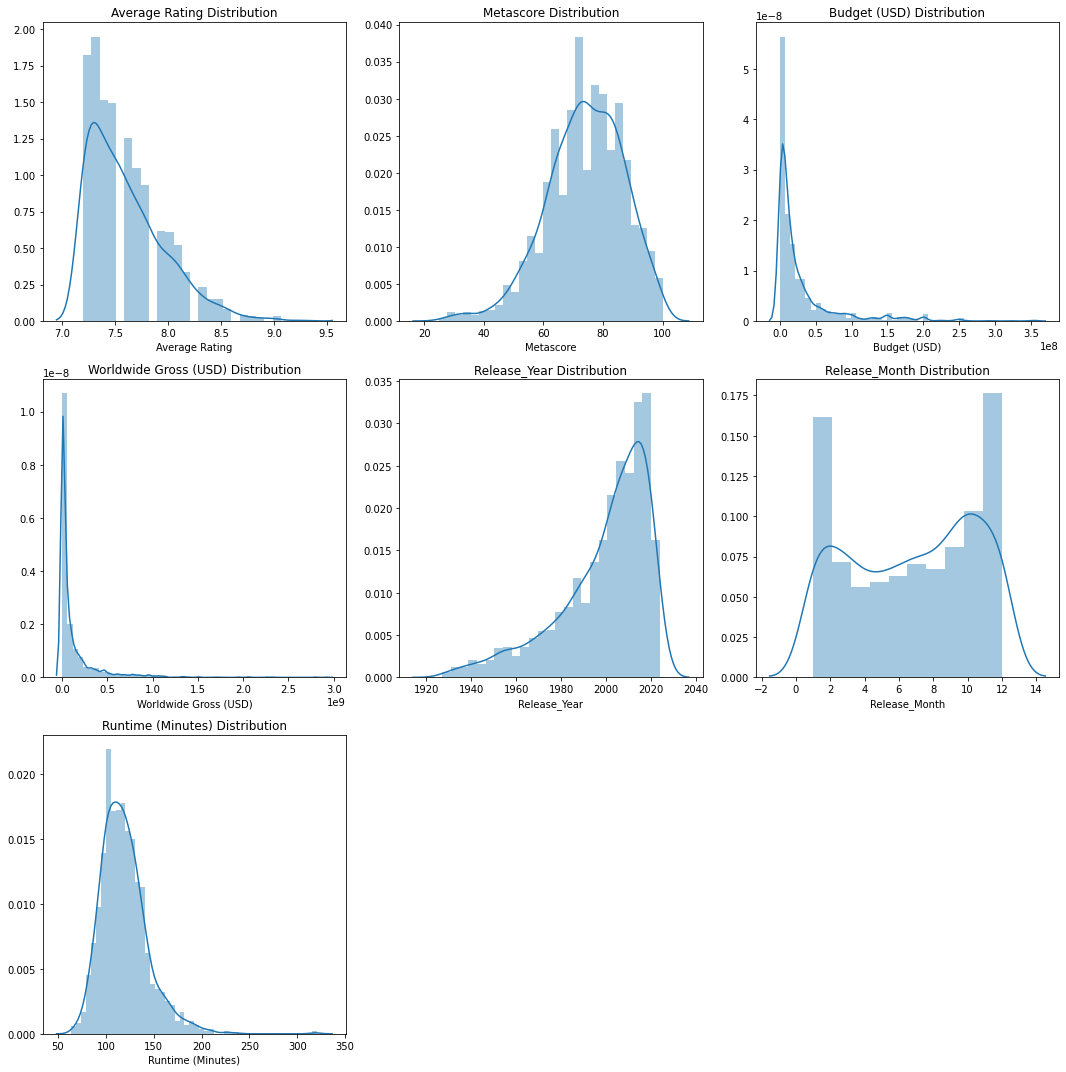

In [313]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lọc các cột numeric
numeric_cols = df.select_dtypes(exclude=["object"]).columns.tolist()

# Tính toán số lượng subplot cần thiết
n = (len(numeric_cols) + 2) // 3
fig, axes = plt.subplots(n, 3, figsize=(15, n * 5))
axes = axes.flatten()

# Vẽ biểu đồ phân phối cho từng cột numeric
for i, col in enumerate(numeric_cols):
    sns.distplot(df[col], ax=axes[i], kde=True)  # Thay histplot bằng distplot
    axes[i].set_title(f"{col} Distribution")

# Ẩn các subplot thừa
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [314]:
print(df.describe())

       Average Rating  Metascore  Budget (USD)  Worldwide Gross (USD)  \
count          1926.0     1926.0        1926.0                 1926.0   
mean              7.6       74.0    29411272.2            125942008.5   
std               0.4       12.9    46591287.4            254748259.0   
min               7.2       25.0          12.7                   19.0   
25%               7.3       66.0     3241896.2              4747928.8   
50%               7.5       75.0    11504514.7             29839267.0   
75%               7.8       83.0    31000000.0            120604751.2   
max               9.3      100.0   356000000.0           2923706026.0   

       Release_Year  Release_Month  Runtime (Minutes)  
count        1926.0         1926.0             1926.0  
mean         1999.2            6.8              119.3  
std            20.3            3.6               24.9  
min          1927.0            1.0               64.0  
25%          1989.0            3.0              102.0  
50%   

**Phân tích**

**1) Chất lượng phim**
- **Average Rating** trung bình: 7.6
- **Metascore** trung bình: 74
- → Cho thấy các phim trong tập dữ liệu có chất lượng khá cao.

**2) Doanh thu và ngân sách**
- **Ngân sách trung bình (Budget):** ~29.4 triệu USD  
- **Doanh thu toàn cầu trung bình (Worldwide Gross):** ~126 triệu USD  
- → Phần lớn phim thu lãi, nhưng: **Độ lệch chuẩn cao** cho thấy sự chênh lệch lớn giữa các phim: có phim lỗ, có phim siêu lợi nhuận.

**3) Thời lượng phim**
- **Thời lượng trung bình:** 119 phút  
- **Khoảng phổ biến:** 102 – 132 phút  
- → Hầu hết phim nằm trong giới hạn thời lượng quen thuộc với khán giả.

**4) Thời gian phát hành**
- **Năm phát hành trung bình:** 1999  
- **Phim được phát hành nhiều nhất trong khoảng:** 1989 – 2014  
- **Tháng phát hành phổ biến:** Tháng 7 và tháng 10  
- → Tập trung vào mùa hè và mùa lễ – thời điểm vàng để ra rạp.

---

**Kết luận**
Các phim trong tập dữ liệu nhìn chung có:
- **Chất lượng cao**, 
- **Khả năng sinh lời tốt**, 
- **Phát hành đúng thời điểm sẽ tối ưu doanh thu.**
- Tuy nhiên, do **biến động lớn về ngân sách và doanh thu**, việc đầu tư sản xuất phim vẫn mang tính rủi ro cao.


## Detect and replace outliers with upper and lower bounds

Numeric features: ['Average Rating', 'Metascore', 'Runtime (Minutes)', 'Budget (USD)', 'Worldwide Gross (USD)', 'Release_Year', 'Release_Month']



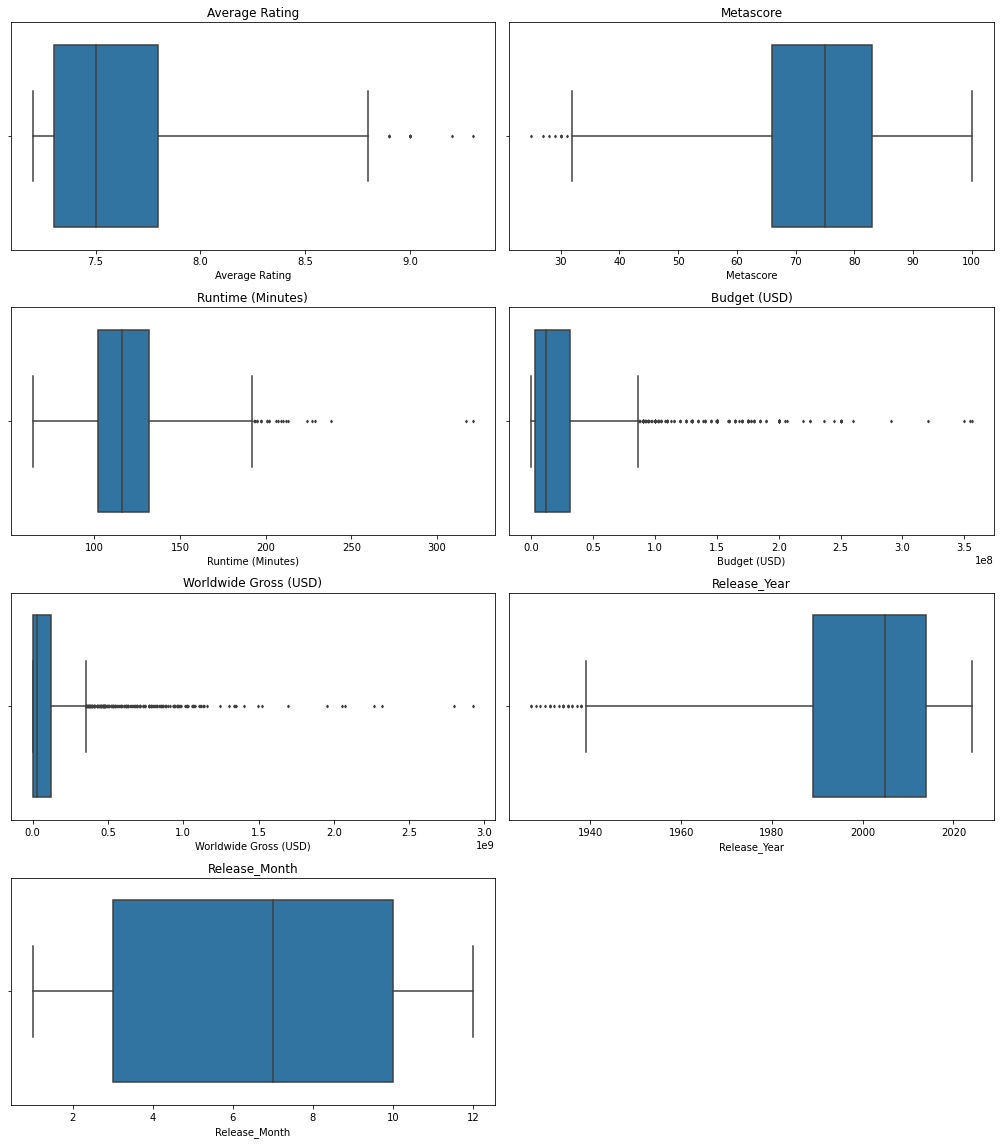

In [315]:
# KIỂM TRA OUTLIERS TRONG CÁC CỘT SỐ BẰNG CÁCH VẼ BIỂU ĐỒ HỘP (BOXPLOT)

numeric_cols = ['Average Rating', 'Metascore', 'Runtime (Minutes)', 'Budget (USD)', 'Worldwide Gross (USD)', 'Release_Year', 'Release_Month']
    # Chọn các cột số để kiểm tra outliers
print(f"Numeric features: {numeric_cols}\n")

# tạo 1 lưới biểu đồ để chứa tất cả các boxplot
n = (len(numeric_cols) + 1) // 2  # Cộng 1 để làm tròn lên
fig, axes = plt.subplots(n, 2, figsize=(14, n * 4))
axes = axes.flatten()

# Vẽ boxplot cho từng cột số
for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df[col], orient="h", ax=axes[i], whis=2, fliersize=2)
    axes[i].set_title(col)

# Ẩn các ô trống còn lại trong grid nếu số biểu đồ < số khung trục.
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Hiển thị biểu đồ gọn gàng, tránh đè chữ.
plt.tight_layout()
plt.show()

In [316]:
# HÀM XÁC ĐỊNH NGƯỠNG OUTLIER TRONG CÁC CỘT SỐ

def outlier_thresholds(df, col, q1=0.25, q3=0.75, verbose=False):
    quartile1 = df[col].quantile(q1)   # Lấy Q1 (mặc định là phần tử thứ 25%)
    quartile3 = df[col].quantile(q3)   # Lấy Q3 (mặc định là phần tử thứ 75%)
    iqr = quartile3 - quartile1        # IQR = Q3 - Q1
    
    upper_bound = quartile3 + 1.5 * iqr # Tính ngưỡng trên
    lower_bound = quartile1 - 1.5 * iqr # Tính ngưỡng dưới
         # Các giá trị lớn hơn upper_bound hoặc nhỏ hơn lower_bound được coi là outliers.

    if verbose:
        print(f"Ngưỡng dưới và ngưỡng trên của cột `{col}` là ({lower_bound:.3f}, {upper_bound:.3f}) , và khoảng tứ phân vị (IQR) là: {iqr:.3f}")
        # In ra các ngưỡng và IQR cho cột hiện tại.

    return lower_bound, upper_bound



# SỬ DỤNG outlier_thresholds() ĐỂ ĐẾM SỐ OUTLIERS TRONG CÁC CỘT SỐ
def check_outliers(df, col, q1=0.25, q3=0.75, verbose=False):
    lower_bound, upper_bound = outlier_thresholds(df, col, q1, q3, verbose)
    outliers_count = df[(df[col] > upper_bound) | (df[col] < lower_bound)][col].count()
    
    if verbose:
        print(f"`Cột {col}` chứa {outliers_count} giá trị ngoại lai (outliers).")
    
    outliers_present = bool(outliers_count > 0)
        # Nếu có ít nhất 1 outlier → Trả về True
        # Nếu không có → False
    
    return outliers_present

In [317]:
# KIỂM TRA CÁC CỘT SỐ CÓ OUTLIERS

cols_with_outliers = []
    # Tạo danh sách rỗng để lưu các cột có chứa outliers

# Duyệt qua từng cột số trong danh sách numeric_cols
for col in numeric_cols:
    if check_outliers(df, col, q1=0.2, q3=0.8, verbose=True):
        print()
        cols_with_outliers.append(col)

Ngưỡng dưới và ngưỡng trên của cột `Average Rating` là (6.400, 8.800) , và khoảng tứ phân vị (IQR) là: 0.600
`Cột Average Rating` chứa 10 giá trị ngoại lai (outliers).

Ngưỡng dưới và ngưỡng trên của cột `Metascore` là (32.500, 116.500) , và khoảng tứ phân vị (IQR) là: 21.000
`Cột Metascore` chứa 10 giá trị ngoại lai (outliers).

Ngưỡng dưới và ngưỡng trên của cột `Runtime (Minutes)` là (46.000, 190.000) , và khoảng tứ phân vị (IQR) là: 36.000
`Cột Runtime (Minutes)` chứa 27 giá trị ngoại lai (outliers).

Ngưỡng dưới và ngưỡng trên của cột `Budget (USD)` là (-53750000.000, 96250000.000) , và khoảng tứ phân vị (IQR) là: 37500000.000
`Cột Budget (USD)` chứa 157 giá trị ngoại lai (outliers).

Ngưỡng dưới và ngưỡng trên của cột `Worldwide Gross (USD)` là (-249638141.500, 422324686.500) , và khoảng tứ phân vị (IQR) là: 167990707.000
`Cột Worldwide Gross (USD)` chứa 164 giá trị ngoại lai (outliers).

Ngưỡng dưới và ngưỡng trên của cột `Release_Year` là (1938.500, 2062.500) , và khoảng tứ phâ

In [318]:
def replace_outliers_with_thresholds(df, col):
    lower_bound, upper_bound = outlier_thresholds(df, col, q1=0.2, q3=0.8)
        # Tính toán ngưỡng dưới và trên cho cột hiện tại
    
    df.loc[df[col] < lower_bound, col] = lower_bound
        # Thay thế các giá trị nhỏ hơn ngưỡng dưới bằng ngưỡng dưới
    df.loc[df[col] > upper_bound, col] = upper_bound
        # Thay thế các giá trị lớn hơn ngưỡng trên bằng ngưỡng trên


# THAY THẾ OUTLIERS TRONG CÁC CỘT CÓ OUTLIERS
for col in cols_with_outliers:
    replace_outliers_with_thresholds(df, col)

# KIỂM TRA LẠI CÁC OUTLIERS SAU KHI ĐÃ THAY THẾ
for col in cols_with_outliers:
    check_outliers(df, col, q1=0.2, q3=0.8, verbose=True)
    print()

Ngưỡng dưới và ngưỡng trên của cột `Average Rating` là (6.400, 8.800) , và khoảng tứ phân vị (IQR) là: 0.600
`Cột Average Rating` chứa 0 giá trị ngoại lai (outliers).

Ngưỡng dưới và ngưỡng trên của cột `Metascore` là (32.500, 116.500) , và khoảng tứ phân vị (IQR) là: 21.000
`Cột Metascore` chứa 0 giá trị ngoại lai (outliers).

Ngưỡng dưới và ngưỡng trên của cột `Runtime (Minutes)` là (46.000, 190.000) , và khoảng tứ phân vị (IQR) là: 36.000
`Cột Runtime (Minutes)` chứa 0 giá trị ngoại lai (outliers).

Ngưỡng dưới và ngưỡng trên của cột `Budget (USD)` là (-53750000.000, 96250000.000) , và khoảng tứ phân vị (IQR) là: 37500000.000
`Cột Budget (USD)` chứa 0 giá trị ngoại lai (outliers).

Ngưỡng dưới và ngưỡng trên của cột `Worldwide Gross (USD)` là (-249638141.500, 422324686.500) , và khoảng tứ phân vị (IQR) là: 167990707.000
`Cột Worldwide Gross (USD)` chứa 0 giá trị ngoại lai (outliers).

Ngưỡng dưới và ngưỡng trên của cột `Release_Year` là (1938.500, 2062.500) , và khoảng tứ phân vị (I

# Tương quan giữa các biến với Worldwide Gross 

# Xác định tầm quan trọng của các biến đầu vào đối với biến mục tiêu Worldwide Gross (USD) bằng mô hình Random Forest.

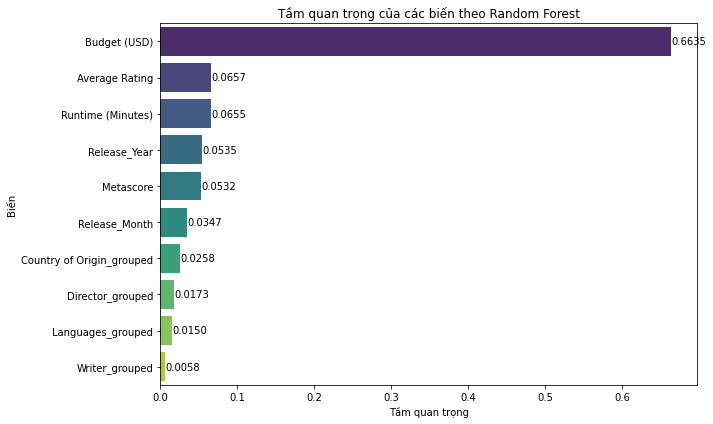

In [319]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns

# Đặt biến mục tiêu
target = "Worldwide Gross (USD)"

# Lưu danh sách mapping từ mã số -> tên nhóm (sẽ dùng để vẽ biểu đồ sau này)
category_mappings = {}  # lưu tất cả mappings của từng cột

cat_cols = ['Director_grouped', 'Writer_grouped', 'Languages_grouped', 'Country of Origin_grouped']

for col in cat_cols:
    df[col] = df[col].astype('category')
    category_mappings[col] = dict(enumerate(df[col].cat.categories))  # lưu lại mapping
    df[col] = df[col].cat.codes  # mã hóa thành số để đưa vào mô hình

# Chọn các biến độc lập (X) — loại bỏ cột mục tiêu
X_cols = [col for col in df.columns if col != target]
X = df[X_cols]
y = df[target]

# Chỉ dùng dữ liệu số
X = X.select_dtypes(exclude="object")

# Tách dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Huấn luyện mô hình Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Lấy tầm quan trọng của các biến
importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances}).sort_values(by="Importance", ascending=False)

# Vẽ biểu đồ với nhãn giá trị
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")

# Thêm giá trị trên từng bar
for i, (importance, feature) in enumerate(zip(importance_df["Importance"], importance_df["Feature"])):
    ax.text(importance + 0.0005, i, f"{importance:.4f}", va='center')


plt.title("Tầm quan trọng của các biến theo Random Forest")
plt.xlabel("Tầm quan trọng")
plt.ylabel("Biến")
plt.tight_layout()
plt.show()

**`Phân tích tầm quan trọng của các biến theo Random Forest`**
1. **Budget** (Ngân sách sản xuất) là biến ảnh hưởng lớn nhất đến doanh thu toàn cầu, chiếm **66.3%** tầm quan trọng. Điều này hợp lý vì ngân sách cao thường đi kèm với chất lượng sản xuất, marketing mạnh, và quy mô phát hành rộng rãi.

2. **Runtime**, **Average Rating**, và **Metascore** có mức độ ảnh hưởng tương đối tương đồng (~6.5%) → cho thấy:
   - Phim dài hơn hoặc được đánh giá cao hơn thường thu hút khán giả nhiều hơn.
   - Các chỉ số đánh giá từ giới chuyên môn (Metascore) và khán giả (Rating) đều đóng vai trò trong việc dự đoán doanh thu.

3. **Release_Year** và **Release_Month** cũng khá quan trọng:
   - Thời điểm phát hành ảnh hưởng lớn đến cơ hội thành công (ví dụ: phát hành mùa lễ hội, cuối tuần, mùa hè...).

4. Các biến định tính đã được mã hóa như:
   - **Country**: 2.5%
   - **Director**, **Languages**, **Writer**: lần lượt là 1.7%, 1.4%, và 0.5%
   → Điều này cho thấy thông tin về quốc gia sản xuất và người đạo diễn có **một phần ảnh hưởng**, nhưng **không phải yếu tố quyết định**.



# Biến liên tục

## Kiểm tra phân phối chuẩn

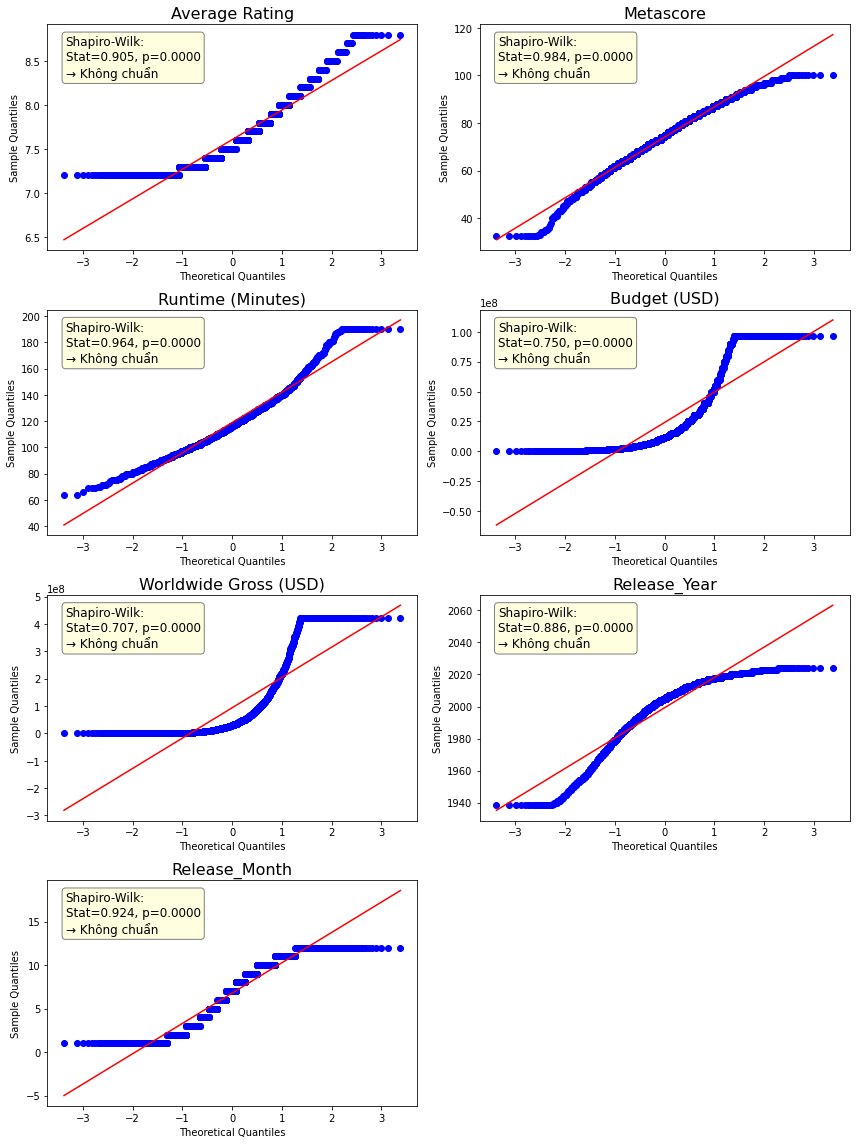

In [320]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro, probplot
import numpy as np


# Tạo lưới 2 cột
n_cols = 2
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))
axes = axes.flatten()  # Flatten để dễ xử lý vòng lặp

for i, col in enumerate(numeric_cols):
    data = df[col].dropna()
    
    # Shapiro-Wilk Test
    stat, p = shapiro(data)
    test_result = "Có thể chuẩn" if p > 0.05 else "Không chuẩn"

    # Vẽ Q-Q Plot
    probplot(data, dist="norm", plot=axes[i])
    axes[i].set_title(f"{col}", fontsize=16)
    axes[i].set_xlabel("Theoretical Quantiles")
    axes[i].set_ylabel("Sample Quantiles")
    
    # Ghi kết quả kiểm định lên biểu đồ
    axes[i].text(0.05, 0.95, 
                 f"Shapiro-Wilk:\nStat={stat:.3f}, p={p:.4f}\n→ {test_result}", 
                 transform=axes[i].transAxes,
                 fontsize=12, 
                 verticalalignment='top',
                 bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", ec="gray", lw=1))

# Ẩn các ô thừa nếu số biến không chia hết cho 2
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Sau khi kiểm tra phân phối chuẩn bằng kiểm định Shapiro-Wilk và Q-Q plot, tất cả các biến số đều không tuân theo phân phối chuẩn, ngay cả sau khi loại bỏ outliers. Do đó, các phương pháp thống kê phi tham số sẽ được sử dụng trong phân tích tiếp theo nhằm đảm bảo tính chính xác và phù hợp với bản chất dữ liệu.


## Tương quan Spearman

Tương quan Spearman với 'Worldwide Gross (USD)':
Budget (USD)         0.8
Release_Year         0.4
Runtime (Minutes)    0.3
Average Rating       0.1
Release_Month       -0.0
Metascore           -0.1
Name: Worldwide Gross (USD), dtype: float64


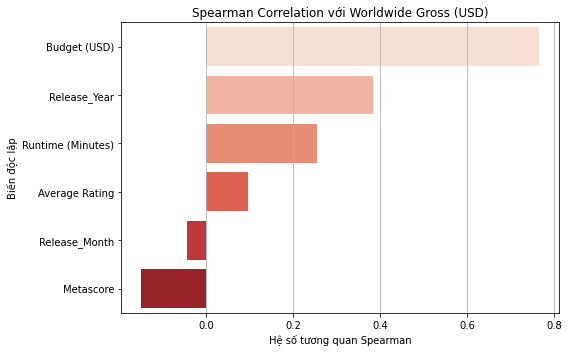

In [321]:

# Tính tương quan Spearman giữa các biến độc lập và Worldwide Gross
spearman_corr = df[numeric_cols].corr(method='spearman')

# Lấy hệ số tương quan với biến mục tiêu
gross_corr = spearman_corr['Worldwide Gross (USD)'].drop('Worldwide Gross (USD)').sort_values(ascending=False)

# In kết quả
print("Tương quan Spearman với 'Worldwide Gross (USD)':")
print(gross_corr.round(3))

# Vẽ biểu đồ tương quan
plt.figure(figsize=(8, 5))
sns.barplot(x=gross_corr.values, y=gross_corr.index, palette="Reds")  # <--- palette hợp lệ
plt.title("Spearman Correlation với Worldwide Gross (USD)")
plt.xlabel("Hệ số tương quan Spearman")
plt.ylabel("Biến độc lập")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


**`Phân tích Tương quan Spearman với Worldwide Gross (USD)`**
- **Budget (USD)** có tương quan mạnh nhất (**0.8**) → Ngân sách lớn thường kéo theo doanh thu cao.
- **Release Year (0.4)** và **Runtime (0.3)** có tương quan trung bình → Phim mới hơn, dài hơn có thể có lợi thế nhẹ.
- **Average Rating (0.1)** tương quan yếu → Đánh giá cao không đảm bảo doanh thu cao.
- **Release Month (~0.0)** và **Metascore (-0.1)** hầu như không có ảnh hưởng rõ rệt đến doanh thu.


In [322]:
from scipy.stats import spearmanr
import pandas as pd

results = {}

for col in numeric_cols:
    if col != 'Worldwide Gross (USD)':
        rho, pval = spearmanr(df[col], df['Worldwide Gross (USD)'])
        results[col] = {'rho': rho, 'pval': pval}

# Tạo DataFrame kết quả
result_df = pd.DataFrame(results).T

# Làm tròn pval 6 chữ số
result_df['pval'] = result_df['pval'].apply(lambda x: f"{x:.18f}")

# Sắp xếp theo độ mạnh tương quan (rho) — dùng để sắp xếp thôi
result_df = result_df.sort_values(by='pval', ascending=True)

# In chỉ cột pval
print("P-value Spearman giữa các biến độc lập và 'Worldwide Gross (USD)':")
print(result_df[['pval']])


P-value Spearman giữa các biến độc lập và 'Worldwide Gross (USD)':
                                   pval
Runtime (Minutes)  0.000000000000000000
Budget (USD)       0.000000000000000000
Release_Year       0.000000000000000000
Metascore          0.000000000041817865
Average Rating     0.000024030690516508
Release_Month      0.047679385400850760


`Phân tích P-value Spearman: Mối tương quan với 'Worldwide Gross (USD)'`

- **Runtime (Minutes)**: Rất có ý nghĩa thống kê. Thời lượng phim có thể ảnh hưởng đến sự quan tâm của khán giả và doanh thu.
- **Budget (USD)**: Rất có ý nghĩa thống kê. Ngân sách là yếu tố rất quan trọng.
- **Release_Year**: Rất có ý nghĩa thống kê. Năm phát hành có mối quan hệ rõ rệt với doanh thu.
- **Metascore**: Rất có ý nghĩa thống kê. Phim được đánh giá cao sẽ thu hút nhiều khán giả hơn.
- **Average Rating**: Có ý nghĩa thống kê. 
- **Release_Month**: Có ý nghĩa thống kê nhưng yếu hơn các yếu tố khác. Mặc dù có ảnh hưởng, nhưng yếu hơn so với các yếu tố khác. 


**`Kết luận chung (Spearman & Random Forest)`**

**1. Ngân sách (Budget)**
- Là yếu tố **ảnh hưởng mạnh nhất** đến doanh thu toàn cầu.
- Cả Spearman (**hệ số tương quan 0.8**) và Random Forest (**66.3% tầm quan trọng**) đều xác nhận điều này.

**=>** Phim có ngân sách lớn thường có cơ hội đạt doanh thu cao hơn nhờ quy mô, chất lượng sản xuất và quảng bá.

**2. Thời lượng phim và năm phát hành (Runtime, Release Year)**
- Có mức ảnh hưởng **trung bình**

**=>** Phim dài hơn và phát hành gần đây có xu hướng doanh thu tốt hơn, có thể do xu hướng thị trường hoặc cải tiến kỹ thuật.

**3. Chất lượng nội dung (Average Rating, Metascore)**
- Tác động **yếu hoặc không rõ ràng**

**=>** Đánh giá cao không đồng nghĩa với doanh thu cao. Doanh thu còn phụ thuộc vào nhiều yếu tố khác như marketing và phân phối.

**4. Các yếu tố định tính (Country, Director, Language, Writer)**
- Random Forest cho thấy **tác động nhỏ nhưng có ý nghĩa nhất định**:
  - Ví dụ: Country (2.5%), Director (1.7%), Language (1.4%), Writer (0.5%)

**=>** Những yếu tố về nguồn gốc và đội ngũ sản xuất có ảnh hưởng nhất định, nhưng không phải yếu tố chính quyết định thành công doanh thu.

**5. Tháng phát hành (Release_Month)**
- Ảnh hưởng **rất yếu hoặc không đáng kể**

**=>** Tháng phát hành có thể có ảnh hưởng nhẹ trong một số trường hợp (như mùa lễ hội, hè), nhưng **không đủ mạnh để trở thành yếu tố chính ảnh hưởng đến doanh thu toàn cầu**.

---

### Tổng kết:
- **Budget** là yếu tố quan trọng nhất.
- Các yếu tố kỹ thuật như **Runtime, Release Year** có ảnh hưởng vừa phải.
- **Chất lượng nội dung và yếu tố định tính** mang tính hỗ trợ, không quyết định.
- **Tháng phát hành** có ảnh hưởng yếu và gần như không phải yếu tố chủ chốt.



## Biểu đồ scatter plot giữa các biến liên tục và Worldwide Gross (USD)

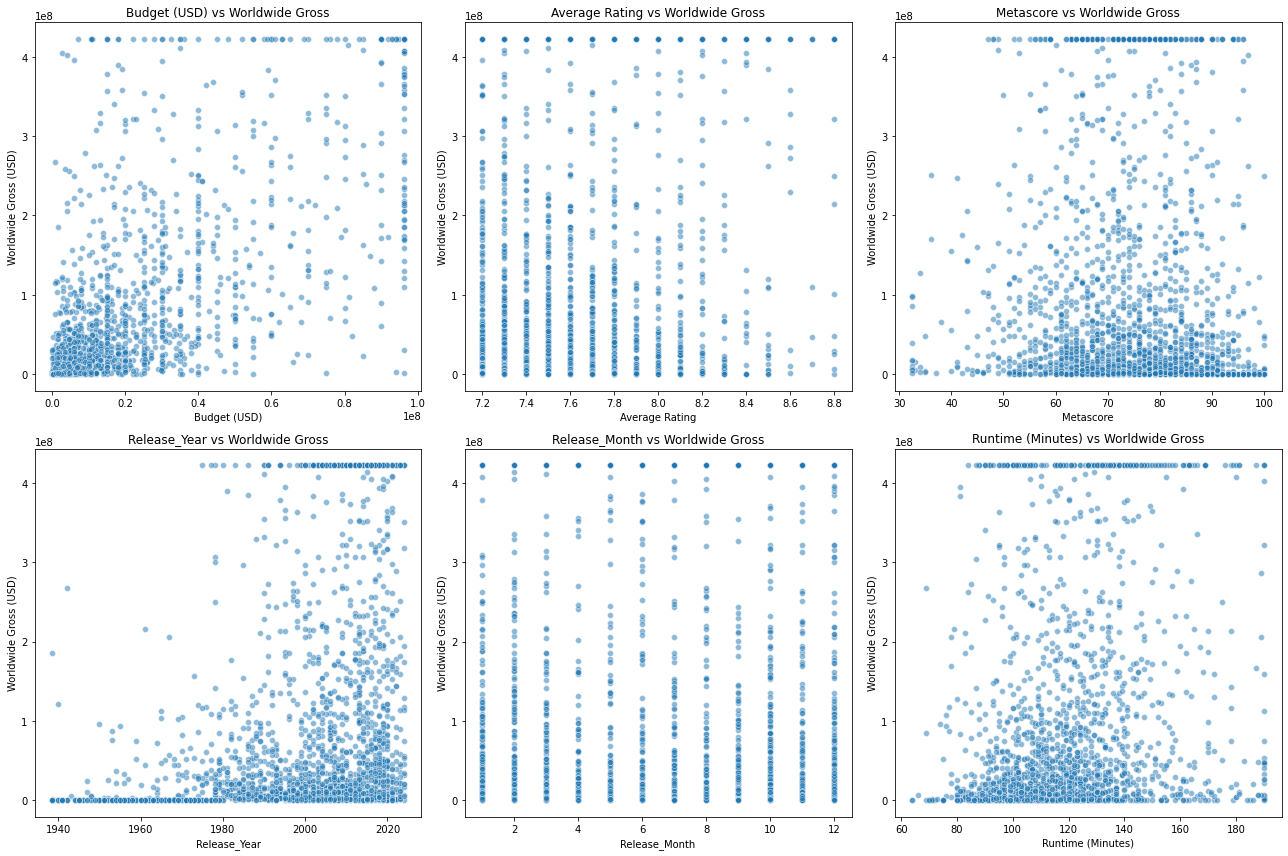

In [330]:
# Danh sách các biến liên tục muốn phân tích
continuous_vars = [
    'Budget (USD)', 'Average Rating', 'Metascore',
    'Release_Year', 'Release_Month', 'Runtime (Minutes)'
]

# Thiết lập kích thước figure
plt.figure(figsize=(18, 12))

# Vẽ từng biểu đồ scatter
for i, var in enumerate(continuous_vars, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(
        data=df, x=var, y='Worldwide Gross (USD)', alpha=0.5
    )
    plt.title(f'{var} vs Worldwide Gross')
    plt.xlabel(var)
    plt.ylabel('Worldwide Gross (USD)')

plt.tight_layout()
plt.show()

## Kiểm tra đa cộng tuyến bằng VIF

In [325]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Giữ lại chỉ các biến liên tục (số thực, số nguyên)
X = df_model.select_dtypes(include=['float64', 'int64']).drop(columns=['Worldwide Gross (USD)'])

# Thêm cột hằng số (constant) để tính VIF
X_const = add_constant(X)

# Tính VIF cho mỗi biến
vif_data = pd.DataFrame()
vif_data['Variable'] = X_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# In kết quả VIF
print("\nVIF (Variance Inflation Factor) của các biến liên tục:")
print(vif_data.round(2))



VIF (Variance Inflation Factor) của các biến liên tục:
            Variable     VIF
0              const 34438.1
1     Average Rating     1.4
2          Metascore     1.2
3       Budget (USD)     3.7
4       Release_Year     1.7
5      Release_Month     1.6
6  Runtime (Minutes)     3.4


`Phân tích VIF (Variance Inflation Factor) của các biến liên tục`

| Biến                   | VIF     | Ý nghĩa                                                                 |
|------------------------|---------|-------------------------------------------------------------------------|
| **const**              | 34438.1 | **Rất cao**: Đây là hằng số (intercept) của mô hình, không phải biến độc lập thực tế. VIF cao ở đây là bình thường và không gây lo ngại. |
| **Average Rating**     | 1.4     | **Không có đa cộng tuyến**: Không có mối quan hệ đáng kể với các biến khác. |
| **Metascore**          | 1.2     | **Không có đa cộng tuyến**: Mối quan hệ yếu với các biến độc lập khác. |
| **Budget (USD)**       | 3.7     | **Mức độ trung bình**: Có chút tương quan với các biến khác, nhưng vẫn trong ngưỡng an toàn (< 5). |
| **Release_Year**       | 1.7     | **Không có đa cộng tuyến**: Tương quan thấp, không gây ảnh hưởng đến mô hình. |
| **Release_Month**      | 1.6     | **Không có đa cộng tuyến**: Ảnh hưởng lẫn nhau giữa các biến là nhỏ. |
| **Runtime (Minutes)**  | 3.4     | **Mức độ trung bình**: Có mối quan hệ vừa phải với các biến khác, nhưng vẫn chấp nhận được. |

---

`Kết luận:`

- **Không có vấn đề đa cộng tuyến nghiêm trọng**: Tất cả các biến độc lập đều có VIF < 5, cho thấy chúng không bị ảnh hưởng lẫn nhau đáng kể.
- **VIF cao ở `const` là bình thường**, không phải là biến cần kiểm soát.
- Do đó, mô hình hồi quy tuyến tính có thể sử dụng các biến này một cách ổn định mà không lo bị sai lệch do đa cộng tuyến.

---

`Tóm lại:`

Mô hình hồi quy hiện tại **an toàn về mặt đa cộng tuyến**, giúp cải thiện độ tin cậy của các hệ số và giảm thiểu rủi ro **overfitting** khi huấn luyện mô hình.


## Xây dựng mô hình GLM 

In [326]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm


all_vars = [
    'Worldwide Gross (USD)', 
    'Budget (USD)', 'Release_Year', 'Runtime (Minutes)', 
    'Average Rating', 'Release_Month', 'Metascore'
]

df_model = df[all_vars].dropna()

# Xây dựng mô hình GLM với phân phối Gaussian
formula = (
    "Q('Worldwide Gross (USD)') ~ Q('Budget (USD)') + Q('Release_Year') + "
    "Q('Runtime (Minutes)') + Q('Average Rating') + Q('Release_Month') + Q('Metascore')"
)

# Tạo mô hình GLM với phân phối Gaussian
model = smf.glm(
    formula=formula,
    data=df_model,
    family=sm.families.Gaussian()
).fit()

# In kết quả phân tích mô hình
print(model.summary())


                     Generalized Linear Model Regression Results                      
Dep. Variable:     Q('Worldwide Gross (USD)')   No. Observations:                 1926
Model:                                    GLM   Df Residuals:                     1919
Model Family:                        Gaussian   Df Model:                            6
Link Function:                       identity   Scale:                      6.0468e+15
Method:                                  IRLS   Log-Likelihood:                -37723.
Date:                        Wed, 23 Apr 2025   Deviance:                   1.1604e+19
Time:                                05:12:37   Pearson chi2:                 1.16e+19
No. Iterations:                             3   Pseudo R-squ. (CS):             0.8453
Covariance Type:                    nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

**`Tổng quan mô hình`**
- Số quan sát (No. Observations): 1926 phim.
- Mô hình sử dụng: GLM với hàm liên kết tuyến tính (link function: identity), phân phối Gaussian (như hồi quy tuyến tính truyền thống).
- Pseudo R-squared (CS): 0.8454 → Cho thấy mô hình giải thích được khoảng 84.5% biến thiên trong biến phụ thuộc – đây là một con số rất cao, tức là mô hình phù hợp tốt với dữ liệu.
- Deviance & Pearson chi2: Dù các giá trị này lớn, điều này là bình thường với dữ liệu có đơn vị lớn như tiền tệ (USD). Quan trọng là xét các hệ số và p-value.

**`Phân tích từng biến:`**

**1) Budget (USD)**
- Hệ số: +3.5487
- P-value: < 0.001 
- Giải thích: Với mỗi 1 đơn vị tăng thêm trong ngân sách (USD), doanh thu toàn cầu tăng trung bình khoảng 3.55 đơn vị (USD), giữ nguyên các yếu tố khác.
- Ý nghĩa thống kê: **Rất mạnh**. Đây là biến có ảnh hưởng lớn nhất và có ý nghĩa thống kê cao nhất trong mô hình.
 
    =>  Ngân sách là yếu tố quan trọng ảnh hưởng tích cực đến doanh thu.

**2) Release_Year**
- Hệ số: +316,800
- P-value: 0.001 
- Giải thích: Các phim phát hành gần đây có xu hướng đạt doanh thu cao hơn, giả định các yếu tố khác không đổi.
- Ý nghĩa thống kê: **Có ý nghĩa mạnh**.

    => Năm phát hành là một yếu tố tích cực và có ý nghĩa thống kê đối với doanh thu.

**3) Runtime (Minutes)**
- Hệ số: -504,200
- P-value: < 0.001 
- Giải thích: Mỗi phút tăng thêm trong thời lượng phim có thể liên quan đến giảm doanh thu toàn cầu khoảng 504,000 USD, giả định các yếu tố khác không đổi.
- Ý nghĩa thống kê: **Rất mạnh**.

    => Thời lượng phim dài hơn có thể ảnh hưởng tiêu cực đến doanh thu – một kết quả ngược với giả định phổ biến.

**4) Average Rating**
- Hệ số: +70,320,000
- P-value: < 0.001 
- Giải thích: Mỗi đơn vị tăng trong điểm đánh giá trung bình (ví dụ từ 6.0 lên 7.0) làm tăng doanh thu khoảng 70 triệu USD.
- Ý nghĩa thống kê: **Rất mạnh**.

    => Đánh giá tích cực từ khán giả có ảnh hưởng lớn đến doanh thu.

**5) Release_Month**
- Hệ số: -720,500
- P-value: 0.142 
- Giải thích: Không có ảnh hưởng đáng kể về mặt thống kê. Mặc dù có hệ số âm, sự khác biệt về doanh thu giữa các tháng phát hành là không đủ rõ ràng để kết luận.

    => **Không có ý nghĩa thống kê**. Có thể cần nhóm lại hoặc kiểm tra thêm theo mùa.

**6) Metascore**
- Hệ số: +261,200
- P-value: 0.088 
- Giải thích: Mỗi điểm Metascore tăng thêm có thể liên quan đến doanh thu tăng khoảng 260,000 USD. Tuy nhiên, **mức ý nghĩa thống kê chưa đạt chuẩn 0.05**.

=> Tác động có tiềm năng, nhưng chưa đủ mạnh để kết luận chắc chắn. Có thể xét thêm tương tác hoặc kiểm tra thêm mẫu.

---
**`Kết luận:`**
- Các biến có ý nghĩa thống kê mạnh: Budget, Release_Year, Runtime, Average Rating.
- Các biến có ý nghĩa yếu hoặc không rõ ràng: Metascore, Release_Month.

**`Ý nghĩa thực tiễn`**
- Phim có ngân sách cao, điểm đánh giá cao, và thời lượng vừa phải có khả năng đạt doanh thu cao hơn.
- Xu hướng thời gian cũng cho thấy các phim hiện đại thường có doanh thu cao hơn – phản ánh sự phát triển của ngành công nghiệp điện ảnh.
- Gợi ý cho các nhà sản xuất: Đầu tư ngân sách mạnh, giữ phim không quá dài, và tập trung cải thiện chất lượng nội dung để có điểm đánh giá cao.



# Biến rời rạc 

In [327]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1926 entries, 0 to 4976
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Title                      1926 non-null   object 
 1   Average Rating             1926 non-null   float64
 2   Metascore                  1926 non-null   float64
 3   Budget (USD)               1926 non-null   float64
 4   Worldwide Gross (USD)      1926 non-null   float64
 5   Release_Year               1926 non-null   float64
 6   Release_Month              1926 non-null   int64  
 7   Runtime (Minutes)          1926 non-null   int64  
 8   Director_grouped           1926 non-null   int8   
 9   Writer_grouped             1926 non-null   int8   
 10  Country of Origin_grouped  1926 non-null   int8   
 11  Languages_grouped          1926 non-null   int8   
dtypes: float64(5), int64(2), int8(4), object(1)
memory usage: 142.9+ KB


## 1. Đạo diễn

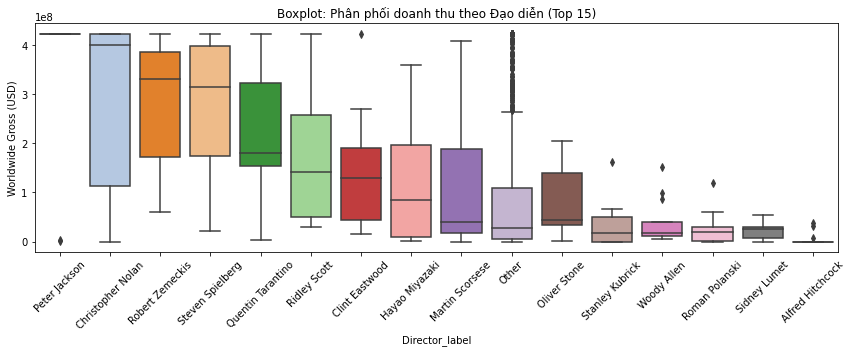

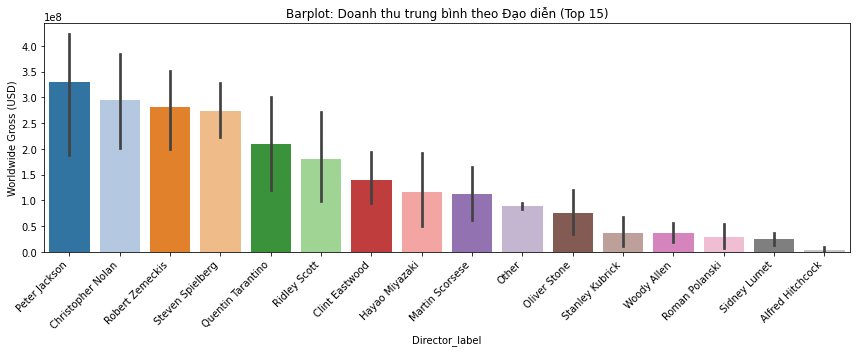

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Tạo cột mới để hiển thị tên đạo diễn thay vì mã số
df['Director_label'] = df['Director_grouped'].map(category_mappings['Director_grouped'])

# Tính trung bình doanh thu theo đạo diễn để xếp thứ tự
order = df.groupby('Director_label')['Worldwide Gross (USD)'].mean().sort_values(ascending=False).index

# Boxplot: Phân phối doanh thu theo đạo diễn
plt.figure(figsize=(12, 5))
sns.boxplot(data=df, x='Director_label', y='Worldwide Gross (USD)', palette='tab20', order=order)
plt.xticks(rotation=45)
plt.title("Boxplot: Phân phối doanh thu theo Đạo diễn (Top 15)")
plt.tight_layout()
plt.show()

# Barplot: Trung bình doanh thu theo đạo diễn (giữ tên)
plt.figure(figsize=(12, 5))
sns.barplot(data=df, x='Director_label', y='Worldwide Gross (USD)', estimator=np.mean, palette='tab20', order=order)
plt.xticks(rotation=45, ha='right')
plt.title('Barplot: Doanh thu trung bình theo Đạo diễn (Top 15)')
plt.tight_layout()
plt.show()


### Boxplot
**Nhận xét:**
- Christopher Nolan (xanh dương nhạt), Steven Spielberg (cam nhạt) và Peter Jackson (xanh dương đậm) có phân phối doanh thu rộng và cao, nghĩa là các phim của họ thường đạt doanh thu lớn, và đôi khi có bom tấn vượt trội (outliers).
- Clint Eastwood (đỏ), Ridley Scott (xanh lá nhạt), Quentin Tarantino (xanh lá đậm) có phân phối trung bình–cao, ổn định hơn (ít outlier hơn các tên tuổi lớn phía trên).
- Nhóm “Other” (các đạo diễn không thuộc top) có phân phối hẹp hơn và thiên về mức thấp → phần lớn phim không quá thành công.
- Sidney Lumet (xám), Roman Polanski (hồng nhạt), Woody Allen (hồng đậm) có doanh thu thấp và hầu như không có phim nổi bật về mặt tài chính.

**Suy ra:**
- Christopher Nolan (xanh dương nhạt) và Peter Jackson (xanh dương đậm) là những đạo diễn có phim thành công rực rỡ (do có outlier rất cao).
- Một số đạo diễn nổi tiếng vẫn có biến động lớn về doanh thu → thành công không đồng đều.

### Barplot
**Nhận xét:**
- Peter Jackson (xanh dương đậm) có doanh thu trung bình cao nhất, vượt cả Christopher Nolan (xanh dương nhạt) và Spielberg (cam nhạt).
- Quentin Tarantino (xanh lá đậm), Robert Zemeckis (cam đậm), và Ridley Scott (xanh lá nhạt) cũng có trung bình doanh thu cao.
- Sidney Lumet (xám), Roman Polanski (hồng nhạt), và Woody Allen (hồng đậm) có doanh thu trung bình rất thấp.
- Nhóm “Other” có doanh thu trung bình thấp nhất → khẳng định rằng Top đạo diễn ảnh hưởng lớn đến thành công tài chính.

**Suy ra:**
- Top đạo diễn tạo ra phim có doanh thu trung bình cao hơn rõ rệt.
- Đạo diễn là một yếu tố ảnh hưởng quan trọng đến doanh thu toàn cầu – đặc biệt là những tên tuổi đã có thương hiệu.
---
### **Kết luận tổng thể:**
- Các đạo diễn hàng đầu như Peter Jackson, Christopher Nolan, và Steven Spielberg có doanh thu phim cao và ổn định, chứng tỏ sức hút mạnh mẽ về mặt thương mại. Trong khi đó, các đạo diễn như Woody Allen hay Sidney Lumet có doanh thu thấp hơn đáng kể.
- Nhóm đạo diễn ngoài top ("Other") chiếm số lượng lớn nhưng thường tạo ra phim có doanh thu thấp, cho thấy tên tuổi đạo diễn là yếu tố quan trọng ảnh hưởng đến thành công tài chính của phim.

## 2. Biên kịch

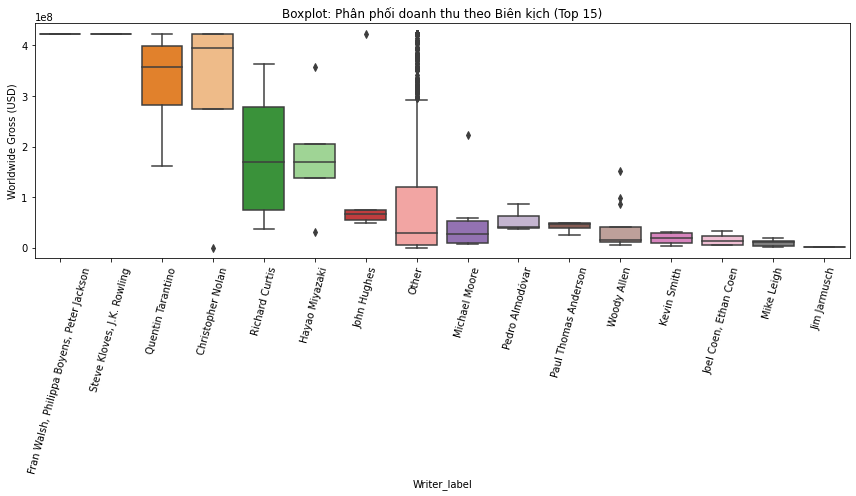

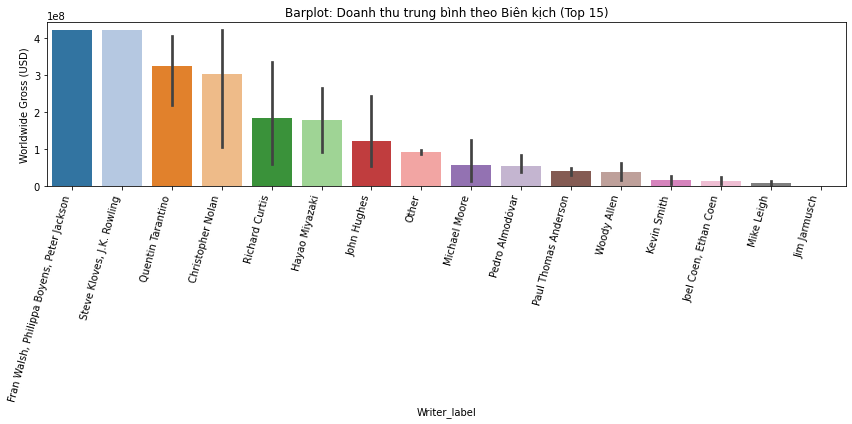

In [ ]:
# Tạo cột mới để hiển thị tên Biên kịch thay vì mã số
df['Writer_label'] = df['Writer_grouped'].map(category_mappings['Writer_grouped'])

# Tính trung bình doanh thu theo Biên kịch để xếp thứ tự
order = df.groupby('Writer_label')['Worldwide Gross (USD)'].mean().sort_values(ascending=False).index

# Boxplot: Phân phối doanh thu theo Biên kịchn
plt.figure(figsize=(12,7))
sns.boxplot(data=df, x='Writer_label', y='Worldwide Gross (USD)', palette='tab20', order=order)
plt.xticks(rotation=75)
plt.title("Boxplot: Phân phối doanh thu theo Biên kịch (Top 15)")
plt.tight_layout()
plt.show()

# Barplot: Trung bình doanh thu theo Biên kịch (giữ tên)
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Writer_label', y='Worldwide Gross (USD)', estimator=np.mean, palette='tab20', order=order)
plt.xticks(rotation=75, ha='right')
plt.title('Barplot: Doanh thu trung bình theo Biên kịch (Top 15)')
plt.tight_layout()
plt.show()


**Boxplot**
- Fran Walsh, Philippa Boyens, Peter Jackson (xanh dương đậm) và Steve Kloves, J.K. Rowling (xanh dương nhạt) có mức doanh thu rất cao và ổn định (phần lớn các giá trị ở gần mức tối đa, ít outlier), chứng tỏ các biên kịch này có khả năng tạo ra nhiều phim bom tấn.
- Quentin Tarantino (cam đậm) và Christopher Nolan (cam nhạt) cũng có mức doanh thu cao, tuy nhiên phân phối rộng hơn, cho thấy sự dao động doanh thu giữa các phim.
- Richard Curtis (xanh lá đậm) có mức dao động lớn – có phim rất ăn khách nhưng cũng có phim doanh thu thấp.
- "Other" (các biên kịch còn lại) có mức phân phối rộng, nhiều outlier → nhóm không đồng nhất về mức ảnh hưởng đến doanh thu.
- Nhóm Jim Jarmusch , Mike Leigh (xám), Joel & Ethan Coen (hồng nhạt), v.v. có phân phối doanh thu thấp và hẹp → ít ảnh hưởng đến doanh thu toàn cầu.

**Barplot**
- Fran Walsh, Philippa Boyens, Peter Jackson (xanh dương đậm) và Steve Kloves, J.K. Rowling (xanh dương nhạt) tiếp tục dẫn đầu với doanh thu trung bình vượt trội (~400 triệu USD).
- Tarantino (cam đậm) và Nolan (cam nhạt) duy trì vị trí cao → cho thấy họ có sự ổn định và ảnh hưởng đến thành công thương mại của phim.
- Các biên kịch như Kevin Smith, Mike Leigh, Jim Jarmusch có mức trung bình rất thấp → phim họ viết không thường đạt doanh thu cao.

---
**Kết luận chung:**
- Biên kịch là một yếu tố có ảnh hưởng rõ ràng đến doanh thu toàn cầu.
- Những tên tuổi lớn như Peter Jackson, J.K. Rowling, Nolan, Tarantino… có khả năng gắn liền với thành công phòng vé.

## 3. Nước xuất xứ

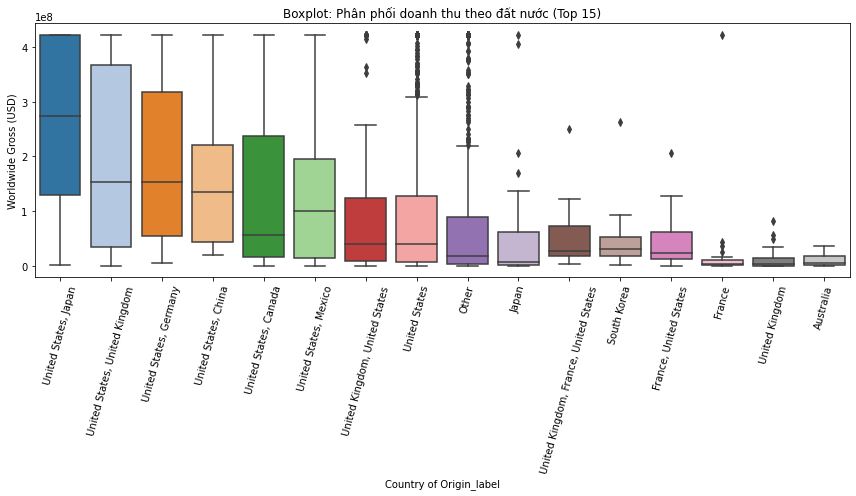

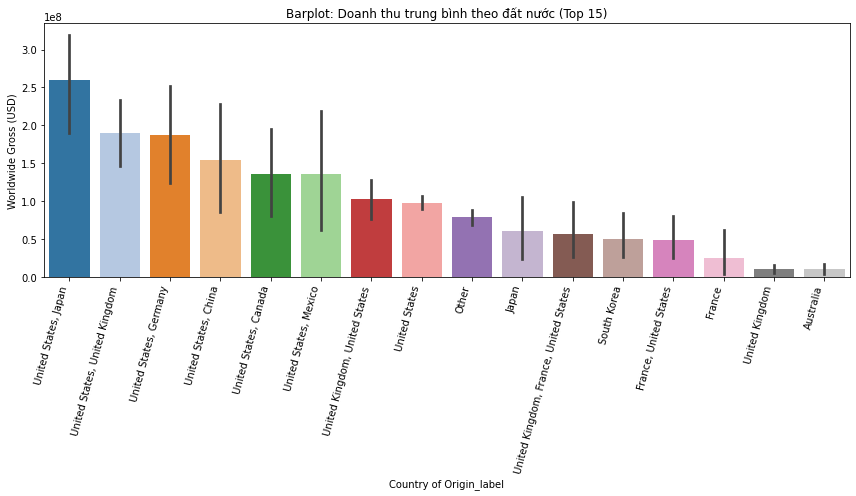

In [283]:
# Tạo cột mới để hiển thị đất nước thay vì mã số
df['Country of Origin_label'] = df['Country of Origin_grouped'].map(category_mappings['Country of Origin_grouped'])

# Tính trung bình doanh thu theo đất nước để xếp thứ tự
order = df.groupby('Country of Origin_label')['Worldwide Gross (USD)'].mean().sort_values(ascending=False).index

# Boxplot: Phân phối doanh thu theo đất nước
plt.figure(figsize=(12, 7))
sns.boxplot(data=df, x='Country of Origin_label', y='Worldwide Gross (USD)', palette='tab20', order=order)
plt.xticks(rotation=75)
plt.title("Boxplot: Phân phối doanh thu theo đất nước (Top 15)")
plt.tight_layout()
plt.show()

# Barplot: Trung bình doanh thu theo đất nước (giữ tên)
plt.figure(figsize=(12, 7))
sns.barplot(data=df, x='Country of Origin_label', y='Worldwide Gross (USD)', estimator=np.mean, palette='tab20', order=order)
plt.xticks(rotation=75, ha='right')
plt.title('Barplot: Doanh thu trung bình theo đất nước (Top 15)')
plt.tight_layout()
plt.show()


### Boxplot
- Nhóm “United States, Japan” (xanh dương đậm) có mức doanh thu cao nhất với median (trung vị) rất cao, đồng thời phân phối rộng – cho thấy nhiều phim có doanh thu vượt trội.
- United Kingdom, Germany, China, Canada, Mexico cũng có median doanh thu tương đối cao, cho thấy các nước này sản xuất ra nhiều phim có doanh thu tốt.
- Nhóm “Other” có phạm vi doanh thu khá rộng, nhưng median không cao – thể hiện có nhiều quốc gia khác góp phần, nhưng không ổn định.
- Các quốc gia như France, South Korea, Australia có doanh thu thấp hơn, phân phối hẹp, tức là ít phim tạo được doanh thu toàn cầu cao.

### Barplot
- United States, Japan (xanh dương đậm) vượt trội về doanh thu trung bình – cho thấy sự kết hợp giữa Mỹ và Nhật (có thể là các hãng hoạt hình lớn như Ghibli hoặc hợp tác quốc tế) mang lại hiệu quả doanh thu rất cao.
- Tiếp theo là United Kingdom, Germany, China, phản ánh tiềm năng lớn từ các nền công nghiệp điện ảnh mạnh.
- Các quốc gia như France, Australia, South Korea có doanh thu trung bình khá thấp – thể hiện dù có một số phim xuất sắc, nhưng trung bình toàn bộ phim từ những nước này không cao.

---
### Kết luận
- Quốc gia xuất xứ ảnh hưởng mạnh đến doanh thu toàn cầu. Các nước có nền điện ảnh phát triển như Mỹ, Nhật, Anh, Đức, Trung Quốc thường sản xuất phim có quy mô lớn, ngân sách cao, dễ tiếp cận thị trường quốc tế hơn.
- Những nước có doanh thu trung bình và median thấp hơn có thể gặp hạn chế về thị trường, phân phối, hoặc không đầu tư nhiều vào phim bom tấn.

## 4. Ngôn ngữ

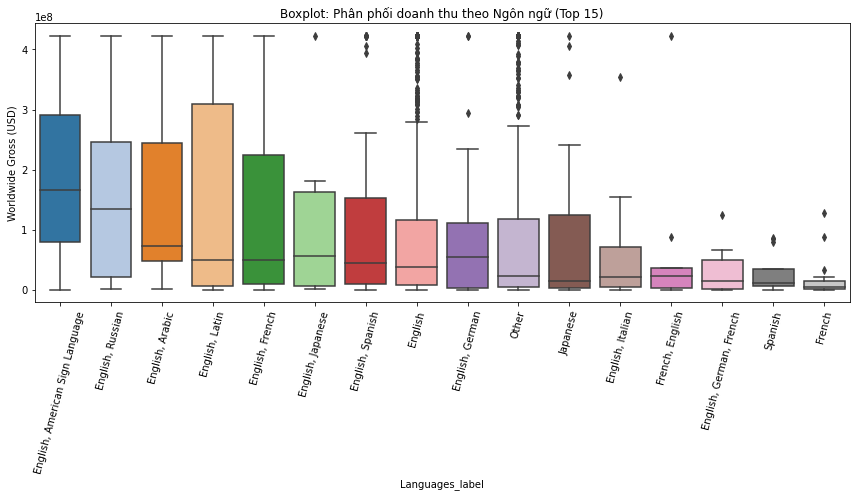

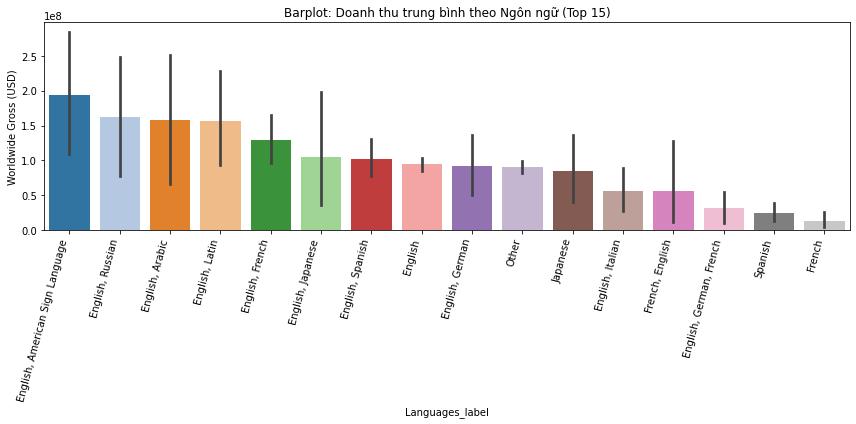

In [284]:
# Tạo cột mới để hiển thị tên thay vì mã số
df['Languages_label'] = df['Languages_grouped'].map(category_mappings['Languages_grouped'])

# Tính trung bình doanh thu theo ngôn ngữ để xếp thứ tự
order = df.groupby('Languages_label')['Worldwide Gross (USD)'].mean().sort_values(ascending=False).index

# Boxplot: Phân phối doanh thu theo ngôn ngữ
plt.figure(figsize=(12,7))
sns.boxplot(data=df, x='Languages_label', y='Worldwide Gross (USD)', palette='tab20', order=order)
plt.xticks(rotation=75)
plt.title("Boxplot: Phân phối doanh thu theo Ngôn ngữ (Top 15)")
plt.tight_layout()
plt.show()

# Barplot: Trung bình doanh thu theo ngôn ngữ (giữ tên)
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Languages_label', y='Worldwide Gross (USD)', estimator=np.mean, palette='tab20', order=order)
plt.xticks(rotation=75, ha='right')
plt.title('Barplot: Doanh thu trung bình theo Ngôn ngữ (Top 15)')
plt.tight_layout()
plt.show()


### Boxplot
- Các phim sử dụng ngôn ngữ English, American Sign Language, Russian, Arabic, và Latin có mức doanh thu khá cao và phân phối rộng.
- Các ngôn ngữ như French, Spanish, và French, English có doanh thu thấp và phân phối hẹp.
- English (một mình) có rất nhiều biến thể (outliers), cho thấy độ dao động lớn về doanh thu.

### Barplot
- Trung bình cao nhất thuộc về English, American Sign Language, theo sau là English, Russian và English, Arabic.
- Các ngôn ngữ Spanish, French, và kết hợp như English, German, French có doanh thu trung bình thấp.

---
### Kết luận:
- Các phim sử dụng tiếng Anh kết hợp với các ngôn ngữ đặc biệt (như American Sign Language, Russian, Arabic) có xu hướng đạt doanh thu cao.
- Phim chỉ sử dụng ngôn ngữ không phải tiếng Anh (như French, Spanish) thường có doanh thu thấp hơn.
- Việc kết hợp ngôn ngữ quốc tế với tiếng Anh có thể là một lợi thế thương mại.

## Phân tích kết hợp

### Director và Writer 

In [ ]:
# Kết hợp Director_label và Writer_label
df['Director_Writer_label'] = df['Director_label'] + ' & ' + df['Writer_label']

In [ ]:
# KIỂM ĐỊNH ANOVA
df_model = df[df['Director_Writer_label'].str.contains('Other') == False]

import statsmodels.formula.api as smf

model = smf.ols("Q('Worldwide Gross (USD)') ~ C(Director_Writer_label)", data=df_model).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)


                                 sum_sq   df    F  PR(>F)
C(Director_Writer) 641145082960793344.0  4.0 16.2     0.0
Residual           246702029823333856.0 25.0  NaN     NaN


- F = 16.2: Hệ số F lớn cho thấy sự khác biệt rõ rệt về doanh thu giữa các cặp đạo diễn-biên kịch.

- p-value = 0.000: Giá trị p rất nhỏ (< 0.05), chứng tỏ sự khác biệt là có ý nghĩa thống kê.

**Kết luận:**
Sự kết hợp giữa đạo diễn và biên kịch có ảnh hưởng đáng kể đến doanh thu toàn cầu của phim. Điều này cho thấy yếu tố con người trong việc xây dựng và đạo diễn phim là một trong những yếu tố then chốt ảnh hưởng đến thành công tài chính.

In [ ]:
# Tính doanh thu trung bình theo nhóm Director và Writer
df_grouped_director_writer = df.groupby('Director_Writer_label')['Worldwide Gross (USD)'].mean()

# Sắp xếp theo doanh thu toàn cầu từ cao xuống thấp
df_grouped_director_writer_sorted = df_grouped_director_writer.sort_values(ascending=False)

# In kết quả doanh thu trung bình của các nhóm
print("Doanh thu trung bình theo nhóm Director và Writer:")
print(df_grouped_director_writer_sorted.head(20))  # Hiển thị 10 kết quả hàng đầu

Doanh thu trung bình theo nhóm Director và Writer:
Director_Writer_label
Peter Jackson & Fran Walsh, Philippa Boyens, Peter Jackson   422324686.5
Other & Steve Kloves, J.K. Rowling                           422324686.5
Quentin Tarantino & Quentin Tarantino                        324276979.4
Christopher Nolan & Christopher Nolan                        302519882.5
Christopher Nolan & Other                                    291023288.2
Robert Zemeckis & Other                                      281187003.8
Steven Spielberg & Other                                     274133376.0
Peter Jackson & Other                                        254053326.5
Other & Richard Curtis                                       184415288.2
Hayao Miyazaki & Hayao Miyazaki                              180309930.6
Ridley Scott & Other                                         179759068.3
Clint Eastwood & Other                                       140016416.5
Other & John Hughes                                

`Phân tích:`

**1) Nhóm Đạo diễn kiêm luôn vai trò biên kịch**
- Quentin Tarantino:	324M
- Christopher Nolan: 302M
- Hayao Miyazaki:	180M

=> Khi đạo diễn cũng là người viết kịch bản, họ thường có tầm nhìn thống nhất → giúp tối ưu chất lượng và thu hút khán giả 


**2) Nhóm Bộ đôi đạo diễn – biên kịch nổi bật** (Cặp ăn ý, quen thuộc, thường làm cùng nhau)
- Peter Jackson & Fran Walsh, Philippa Boyens, Peter Jackson:	422M

=> Bộ 3 ăn ý, thường hợp tác trong các dự án phim lớn như The Lord of the Rings, The Hobbit -> rất hiệu quả về mặt doanh thu.


**3) Nhóm Đạo diễn nổi tiếng + Biên kịch không quen thuộc**
(Khi đạo diễn lớn hợp tác với biên kịch ít tiếng tăm)
- Christopher Nolan & Other:	291M
- Peter Jackson & Other:	254M
- Steven Spielberg & Other:	274M
- Ridley Scott & Other:	179M
- Clint Eastwood & Other:	140M

=> Dù vẫn khá cao, nhưng doanh thu giảm nhẹ so với khi họ tự viết hoặc hợp tác với người quen. Điều này cho thấy:
- Tên tuổi đạo diễn có thể duy trì mức doanh thu ổn định
- Nhưng mức đột phá thường đến từ đội ngũ sáng tạo ăn ý.


**4) Nhóm Biên kịch mạnh + Đạo diễn không nổi bật**
(Khi biên kịch giỏi giúp nâng tầm dự án)
- Other & Steve Kloves, J.K. Rowling (loạt phim Harry Potter):	422M
- Other & Richard Curtis:	184M
- Other & John Hughes:	121M

=> Dù đạo diễn không nổi bật, biên kịch nổi tiếng vẫn giúp phim đạt doanh thu cao.
(Kịch bản hấp dẫn + nội dung mạnh có thể bù đắp cho đạo diễn không có tiếng.)


`Kết luận rút ra`
- Đạo diễn kiêm biên kịch hoặc bộ đôi thân thiết tạo nên bom tấn.
- Tên tuổi lớn + đội ngũ kịch bản yếu = doanh thu giảm nhẹ.
- Biên kịch giỏi có thể giúp phim "bình thường" bán tốt hơn.

### Quốc gia gốc (Country of Origin) và Ngôn ngữ (Languages) 

In [285]:
# Kết hợp Director_label và Writer_label
df['Country_Languages_label'] = df['Country of Origin_label'] + ' & ' + df['Languages_label']

In [286]:
# ANOVA theo Country và Languages đã kết hợp
model_country_languages = smf.ols("Q('Worldwide Gross (USD)') ~ C(Country_Languages_label)", data=df).fit()
anova_country_languages = sm.stats.anova_lm(model_country_languages, typ=2)
print("ANOVA theo Country và Languages đã kết hợp:")
print(anova_country_languages)


ANOVA theo Country và Languages đã kết hợp:
                                           sum_sq     df   F  PR(>F)
C(Country_Languages_label)  5182142515314419712.0   91.0 3.7     0.0
Residual                   28153076343745003520.0 1834.0 NaN     NaN


- F = 3.7: Hệ số F cho thấy có sự khác biệt đáng kể về doanh thu giữa các nhóm quốc gia - ngôn ngữ khác nhau.
- p-value = 0.000: Giá trị p rất nhỏ (< 0.05), nghĩa là kết quả có ý nghĩa thống kê.

**Kết luận:**
- Sự kết hợp giữa quốc gia sản xuất và ngôn ngữ chính có ảnh hưởng rõ rệt đến doanh thu toàn cầu của phim. Điều này có thể phản ánh:
- Sức hút của thị trường nội địa và quốc tế,
- Khả năng tiếp cận khán giả toàn cầu thông qua ngôn ngữ,
- Văn hóa điện ảnh và chất lượng sản xuất theo từng khu vực.

In [290]:
# Tính doanh thu trung bình theo nhóm 
df_grouped_country_languages = df.groupby('Country_Languages_label')['Worldwide Gross (USD)'].mean()

# Sắp xếp theo doanh thu toàn cầu từ cao xuống thấp
df_grouped_country_languages_sorted = df_grouped_country_languages.sort_values(ascending=False)

# In kết quả doanh thu trung bình của các nhóm
print("Doanh thu trung bình theo nhóm Country và Language:")
print(df_grouped_country_languages_sorted.head(20))  # Hiển thị 20 kết quả hàng đầu

Doanh thu trung bình theo nhóm Country và Language:
Country_Languages_label
Other & English, American Sign Language                           422324686.5
United Kingdom, United States & English, Latin                    422324686.5
United States, United Kingdom & English, Arabic                   422324686.5
United States, Japan & English, French                            422324686.5
United States, Japan & English, German                            422324686.5
United States, Japan & English, Spanish                           422324686.5
United States, Canada & English, French                           352114312.0
United States, Germany & English, French                          318809514.2
United States, Japan & English                                    316208156.1
United States, China & English, Arabic                            251171807.0
United States, United Kingdom & Other                             239573982.9
United States, United Kingdom & English, Spanish                  

`Phân tích:`

**1) Nhóm hợp tác sản xuất quốc tế – Ngôn ngữ phong phú**
- United States, Japan & English, French: 422M
- United States, Japan & English, German: 422M
- United States, Japan & English, Spanish: 422M
- United Kingdom, United States & English, Latin: 422M

=> Những bộ phim đến từ sự hợp tác giữa Mỹ – Nhật – Anh và sử dụng đa ngôn ngữ thường đạt doanh thu rất cao.

Giải thích:
- Có khả năng phát hành rộng khắp.
- Nội dung đa văn hóa, phù hợp khán giả toàn cầu.
- Thường là các phim bom tấn, franchise lớn (như Harry Potter, Studio Ghibli, Avengers...).


**2) Nhóm quốc gia lớn + thêm ngôn ngữ phụ**
- United States & English, Russian: 216M
- United States & English, German: 211M
- United States & English, Arabic: 251M

=> Thêm các ngôn ngữ phụ giúp mở rộng thị trường nhưng không vượt quá hiệu quả của nhóm hợp tác quốc tế.

Giải thích:
- Ngôn ngữ phụ có thể hỗ trợ phân phối nội dung ở khu vực cụ thể (Trung Đông, Nga, Đức).
- Tuy nhiên, nếu không có yếu tố sản xuất đa quốc gia thì hiệu quả chưa cao bằng nhóm đầu.

**3) Nhóm “Other” & English**
- Other & English, Japanese: 211M
- Other & English, Russian: 194M
- Other & English, American Sign Language: 422M

=> Dữ liệu "Other" cho thấy có sự phân hóa cao.

Giải thích:
- Có thể bao gồm các dự án độc lập hoặc phim đặc biệt (arthouse, festival).
- Một số có doanh thu đột phá nếu được đầu tư tốt, nhưng phần lớn còn phụ thuộc nhiều yếu tố khác (thương hiệu, chiến lược phát hành).

`Kết luận rút ra:`
- Hợp tác sản xuất giữa nhiều quốc gia lớn + đa ngôn ngữ giúp phim tiếp cận khán giả toàn cầu → doanh thu cao nhất.
- Thêm ngôn ngữ phụ mở rộng thị trường nhưng hiệu quả chỉ thực sự nổi bật khi đi kèm sản xuất chất lượng.